In [1]:
import sys
sys.path.append("/dataz/dsa110/imaging/dsa110-nsfrb/")
import nsfrb.searching as sl
from PIL import Image,ImageOps
import numpy as np
from scipy.stats import norm
import os
import copy
from matplotlib import pyplot as plt
from simulations_and_classifications import generate_source_images as gsi

In [2]:

from simulations_and_classifications import generate_source_images as gsi

In [272]:
gsi.generate_src_images(dataset_dir='/home/ubuntu/proj/dsa110-shell/dsa110-nsfrb/simulations_and_classifications/src_examples/observation_1/images/32x32_images/',
                       num_observations=1,
                       noise_std_low=1,
                       noise_std_high=2,
                       exclude_antenna_percentage=[0,0.15],
                       HA_low=0,
                       HA_high=10/180*np.pi,
                       Dec_low=-np.pi/2,
                       Dec_high=np.pi/2,
                       spectral_index_low=-2,
                       spectral_index_high=2,
                       zoom_pix=32)

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

All observations saved.


In [207]:
np.nanargmax

<function numpy.nanargmax(a, axis=None)>

# function to make test images of desired dimensions using Nikita's png's

subband_avg_1416.86_MHz.png
subband_avg_1393.42_MHz.png
subband_avg_1311.39_MHz.png
subband_avg_1440.29_MHz.png
subband_avg_1323.11_MHz.png
subband_avg_1452.01_MHz.png
subband_avg_1334.82_MHz.png
subband_avg_1428.57_MHz.png
subband_avg_1381.70_MHz.png
subband_avg_1463.73_MHz.png
subband_avg_1475.45_MHz.png
subband_avg_1487.17_MHz.png
subband_avg_1369.98_MHz.png
subband_avg_1358.26_MHz.png
subband_avg_1346.54_MHz.png
subband_avg_1405.14_MHz.png


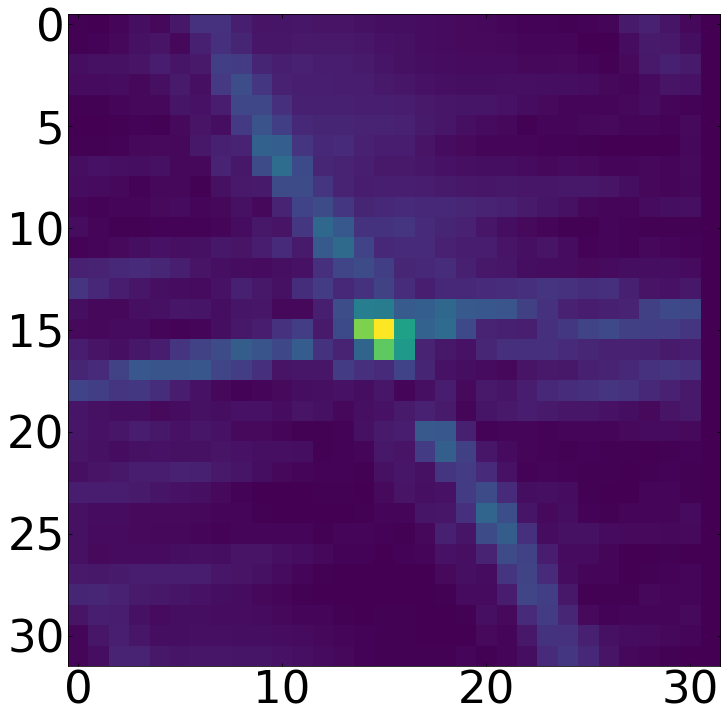

subband_avg_1416.86_MHz.png
subband_avg_1393.42_MHz.png
subband_avg_1311.39_MHz.png
subband_avg_1440.29_MHz.png
subband_avg_1323.11_MHz.png
subband_avg_1452.01_MHz.png
subband_avg_1334.82_MHz.png
subband_avg_1428.57_MHz.png
subband_avg_1381.70_MHz.png
subband_avg_1463.73_MHz.png
subband_avg_1475.45_MHz.png
subband_avg_1487.17_MHz.png
subband_avg_1369.98_MHz.png
subband_avg_1358.26_MHz.png
subband_avg_1346.54_MHz.png
subband_avg_1405.14_MHz.png
1.0 375391.796875
1.0 371692.578125
1.0 374882.421875
0.9999999999999999 375242.1875
1.0 376885.546875
1.0 372671.875
1.0 373516.40625
1.0 374998.046875
1.0 374307.03125
1.0 375801.5625
1.0 373971.484375
1.0 373700.78125
1.0 377119.921875
1.0 372586.71875
1.0 376637.890625
1.0 377326.171875
(2025.4329188460526, array([ 1.97504190e-01,  1.05940023e-02, -2.70479096e-01, -1.36197719e-01,
       -5.83080416e-02, -9.77163051e-02,  1.91839438e-01,  8.99251876e-01,
        7.10414843e-01,  3.40682838e-01,  4.52684216e-01,  9.13660025e-02,
        1.9962

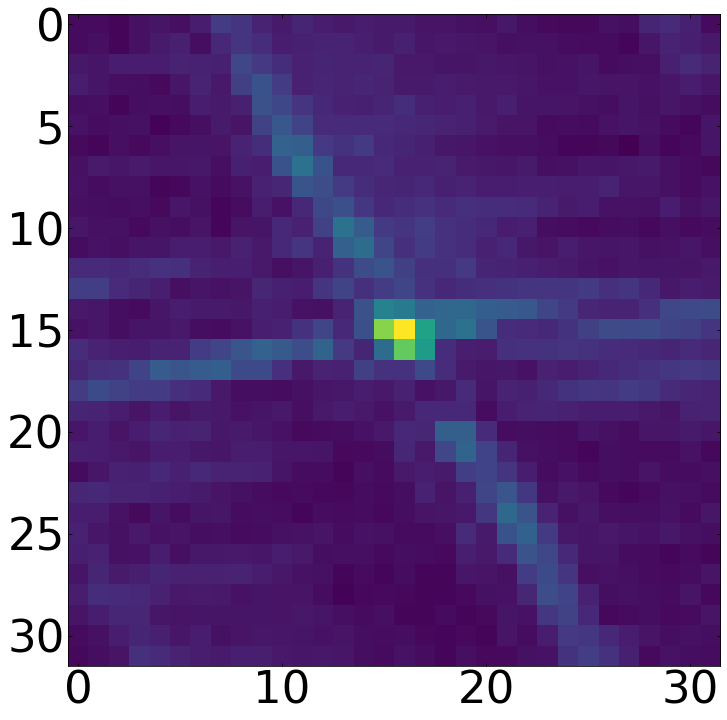

In [8]:
datagridsize = 256
def make_PSF_cube(loc=0.5,gridsize=32,nchans=16,nsamps=1000,RFI=False):
    #make pngs
    """
    gsi.generate_src_images(dataset_dir='/home/ubuntu/proj/dsa110-shell/dsa110-nsfrb/simulations_and_classifications/',#src_examples/testimgs_2024-03-18/{a}x{a}_images/'.format(a=gridsize),
                       num_observations=2,
                       noise_std_low=1,
                       noise_std_high=2,
                       exclude_antenna_percentage=[0,0.15],
                       HA_low=0,
                       HA_high=25/180*np.pi,
                       Dec_low=-np.pi/2,
                       Dec_high=np.pi/2,
                       spectral_index_low=-2,
                       spectral_index_high=2,
                       zoom_pix=gridsize)
    """
    
    #get pngs
    dirname = "/home/ubuntu/proj/dsa110-shell/dsa110-nsfrb/simulations_and_classifications/src_examples/observation_2/images/"
    pngs = os.listdir(dirname)
    sourceimg = np.zeros((gridsize,gridsize,nsamps,nchans))
    freqs = []
    fs = []
    
    for png in pngs:
        print(png)
        if ".png" in png:
            #get frequency
            freq = float(png[png.index("avg_") + 4: png.index("avg_") + 11])
            freqs.append(freq)
            fs.append(png)

    freqs_sorted = np.sort(freqs)
    fs_sorted = [x for x, _ in sorted(zip(fs, freqs))]
    #downsample and copy over time and frequency axes
    for i in range(nchans):
        for j in range(nsamps):
            #print(np.asarray(ImageOps.grayscale(Image.open(dirname + fs_sorted[i]))).shape)
            sourceimg[:,:,j,i] = np.asarray(ImageOps.grayscale(Image.open(dirname + fs_sorted[i]))).reshape((gridsize,datagridsize//gridsize,gridsize,datagridsize//gridsize)).mean((1,3))

    #roll if not perfectly centered
    maxpix = tuple(np.array(np.unravel_index(np.argmax(sourceimg[:,:,0,0].flatten()),(gridsize,gridsize))))
    centerpix = ((gridsize//2) - 1,(gridsize//2) - 1)
    if maxpix != centerpix:
    
        rolledPSFimg = np.roll(np.roll(sourceimg,shift=centerpix[0]-maxpix[0],axis=0),shift=centerpix[1]-maxpix[1],axis=1)
        rolledPSFimg[gridsize - (maxpix[0]-centerpix[0]):,:,:,:] = 0
        rolledPSFimg[:,gridsize - (maxpix[1]-centerpix[1]):,:,:] = 0
    else: rolledPSFimg = PSFimg
    #cutout image
    #PSFimg = rolledPSFimg[gridsize//2:gridsize//2 + gridsize,gridsize//2:gridsize//2 + gridsize]


    return rolledPSFimg
    """
    #center
    maxpix = np.unravel_index(np.argmax(sourceimg[:,:,0,0]),(gridsize*2,gridsize*2))
    
    if maxpix[0]-gridsize < 0: 
        min1,max1 = 0,gridsize
    elif maxpix[0]+gridsize>gridsize*2:
        min1,max1 = gridsize,gridsize*2
    else: 
        min1,max1 = maxpix[0]-gridsize,maxpix[0]+gridsize

    if maxpix[1]-gridsize<0:
        min2,max2 = 0,gridsize
    elif maxpix[1]+gridsize>gridsize*2:
        min2,max2 = gridsize,gridsize*2
    else:
        min2,max2 = maxpix[1]-gridsize,maxpix[1]+gridsize
    PSFimg = sourceimg[min1:max1,min2:max2,:,:]

    
    return PSFimg

    """

def get_SNR(img,PSFimg,wid,loc,noises=np.ones(16),mode='4d'):
    """
    Computes the signal-to-noise of the input image given the PSF centered on the source. Mode='4d' assumes the input has a frequency axis
    while mode='3d' does not.
    """

    boxcar = np.zeros(img.shape[2])
    boxcar[loc:loc+wid] = 1

    if mode.lower() == '4d':
        #timeseries = np.sum(img.mean(3)*PSFimg.mean(3),axis=(0,1))
        timeseries = np.nansum(np.nansum((img/np.array(noises)),3)*np.nanmean(PSFimg,3)/(np.nansum(1/np.array(noises))),axis=(0,1))
    elif mode.lower() == '3d':
        #timeseries = np.sum(img*PSFimg,axis=(0,1))
        timeseries = np.nansum((img/np.nanmean(noises))*PSFimg/(np.nansum(1/np.nanmean(noises))),axis=(0,1))
        
    csig = np.convolve(timeseries,boxcar,'same')#/np.sum(boxcar)
    s=np.nanstd(np.concatenate([csig[:np.nanargmax(csig)-wid],csig[np.nanargmax(csig)+wid+1:]]))
    
    return np.max(csig)/s,csig#, np.argmax(csig)

    
def make_image_cube(PSFimg,snr=1000,width=5,loc=0.5,gridsize=32,nchans=16,nsamps=1000,RFI=False):
    #get pngs
    """
    gsi.generate_src_images(dataset_dir='/home/ubuntu/proj/dsa110-shell/dsa110-nsfrb/simulations_and_classifications/',#src_examples/testimgs_2024-03-18/{a}x{a}_images/'.format(a=gridsize),
                       num_observations=2,
                       noise_std_low=1,
                       noise_std_high=2,
                       exclude_antenna_percentage=[0,0.15],
                       HA_low=0,
                       HA_high=25/180*np.pi,
                       Dec_low=-np.pi/2,
                       Dec_high=np.pi/2,
                       spectral_index_low=-2,
                       spectral_index_high=2,
                       zoom_pix=gridsize)
    """
    
    dirname = "/home/ubuntu/proj/dsa110-shell/dsa110-nsfrb/simulations_and_classifications/src_examples/observation_2/images/"#testimgs_2024-03-18/"#{a}x{a}_images/"#src_examples/observation_1/images/".format(a=gridsize)
    pngs = os.listdir(dirname)
    sourceimg = np.zeros((gridsize,gridsize,nsamps,nchans))
    freqs = []
    fs = []
    
    for png in pngs:
        print(png)
        if ".png" in png:
            #get frequency
            freq = float(png[png.index("avg_") + 4: png.index("avg_") + 11])
            freqs.append(freq)
            fs.append(png)

    freqs_sorted = np.sort(freqs)
    fs_sorted = [x for x, _ in sorted(zip(fs, freqs))]

    for i in range(nchans):
        for j in range(width):
            sourceimg[:,:,int(loc*nsamps)+j,i] = np.asarray(ImageOps.grayscale(Image.open(dirname + fs_sorted[i]))).reshape((gridsize,datagridsize//gridsize,gridsize,datagridsize//gridsize)).mean((1,3))

    #now add noise based on the SNR
    #PSFimg = make_PSF_cube(loc=loc,gridsize=gridsize,nchans=nchans,nsamps=nsamps)
    #sourceimg = sourceimg[gridsize//2:gridsize//2 + gridsize,gridsize//2:gridsize//2 + gridsize]
    noises = []
    for i in range(nchans):
        sourceimg[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i] = sourceimg[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i]/(np.sum((PSFimg*sourceimg)[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i]))#/np.sum(PSFimg[:,:,:,i]))
        
        
        print(np.sum((PSFimg*sourceimg)[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i]),np.sum(PSFimg[:,:,:,i]))
        
    
        #img[16,16,500:500+wid,:] = snr/wid
        sourceimg[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i] = sourceimg[:,:,int(loc*nsamps) : int(loc*nsamps) + width,i]*snr#/np.sum(PSFimg[:,:,0,i])
        
        
        sourceimg[:,:,:,i] += norm.rvs(loc=0,scale=np.sqrt(1/np.sum(PSFimg[:,:,0,i])/width/nchans),size=(gridsize,gridsize,nsamps))
        noises.append(1/np.sum(PSFimg[:,:,0,i])/width/nchans)

    
    return sourceimg




plt.figure(figsize=(12,12))
PSFimg = make_PSF_cube(gridsize=32,nsamps=25)
plt.imshow(PSFimg[:,:,25//2,0])
plt.show()

import copy 
img = make_image_cube(PSFimg=PSFimg,gridsize=32,nsamps=25)

print(get_SNR(img,PSFimg,5,loc=25//2))#,noises=noises))
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,25//2,0])
plt.show()

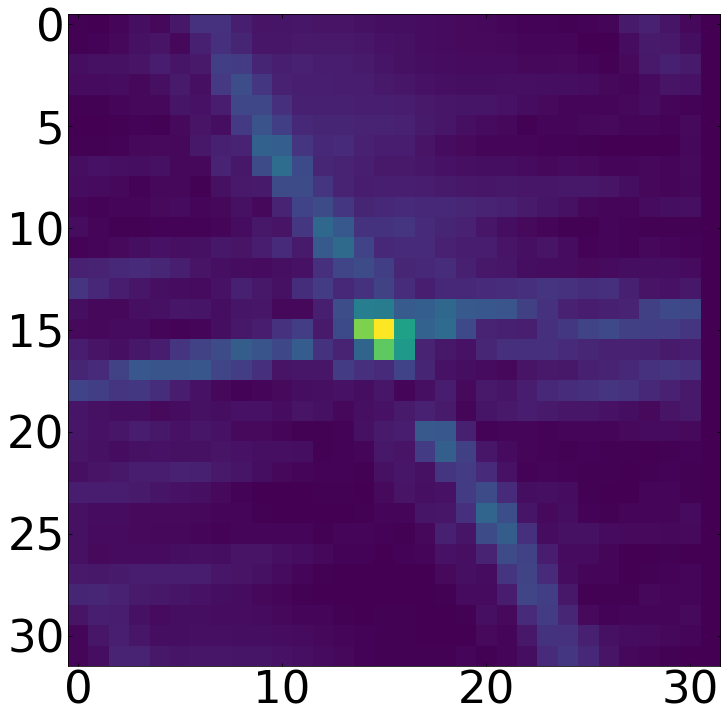

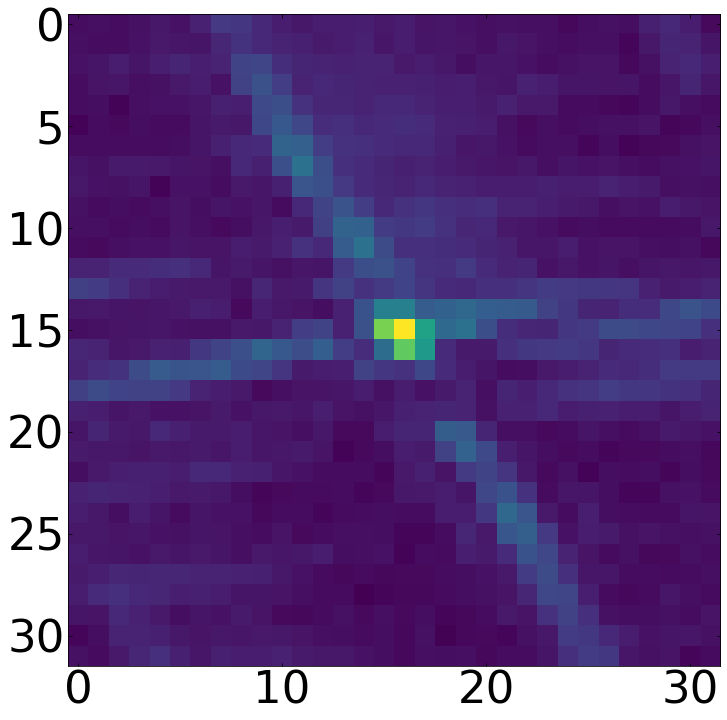

In [9]:

plt.figure(figsize=(12,12))
PSFimg = sl.make_PSF_cube(gridsize=32,nsamps=75)
plt.imshow(PSFimg[:,:,75//2,0])
plt.show()

import copy 
img = sl.make_image_cube(PSFimg=PSFimg,gridsize=32,nsamps=75)

#print(get_SNR(img,PSFimg,5,loc=25//2))#,noises=noises))
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,75//2,0])
plt.show()

In [200]:
datagridsize

256

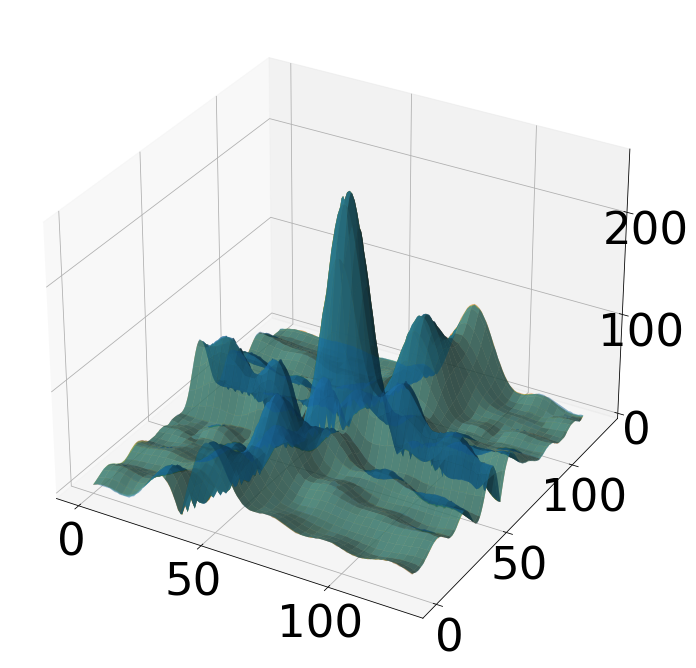

In [389]:
plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1,projection='3d')
x,y= np.meshgrid(np.arange(128),np.arange(128))
#ax.plot_surface(x,y,img[:,:,25//2,0])
ax.plot_surface(x,y,PSFimg[:,:,25//2,0],alpha=0.5)
ax.plot_surface(x,y,PSFimg[:,:,25//2,1],alpha=0.5)
ax.plot_surface(x,y,PSFimg[:,:,25//2,:].mean(2),alpha=0.5)
#ax.view_init(0)
plt.show()

In [148]:

from scipy.signal import convolve2d
from scipy.signal import correlate2d
def matched_filter_space(image_tesseract,PSFimg):
    """
    Matched filter via convolution w/ DSA-110 core PSF
    """

    image_tesseract_filtered = np.zeros(image_tesseract.shape)
    nsamps = image_tesseract.shape[2]
    nchans = image_tesseract.shape[3]
    for i in range(nsamps):
        for j in range(nchans):
            image_tesseract_filtered[:,:,i,j] = convolve2d(image_tesseract[:,:,i,j],PSFimg[:,:,i,j],mode='same') #assume the PSF is already centered

    return image_tesseract_filtered
    
    
    np.nansum(np.nansum((img/np.array(noises)),3)*np.nanmean(PSFimg,3)/(np.nansum(1/np.array(noises))),axis=(0,1))


def snr_vs_RA_DEC_new(image_tesseract_filtered_dm,wid,mode='4d',noiseth=5,plot=False):
    """
    alternate implementation of SNR w/ 2d convolution to do PSF matched filtering. input is 3d array with axes gridsize x gridsize x nsamps
    """
    nsamps = image_tesseract_filtered_dm.shape[2]
    #ndms = image_tesseract.shape[3]
    gridsize = image_tesseract_filtered_dm.shape[0]
    loc = gridsize//2
    

    #make a boxcar filter for time
    boxcar = np.zeros(image_tesseract_filtered_dm.shape[2])
    boxcar[loc-wid//2-2:loc+wid-wid//2-2] = 1

    if plot:
        plt.figure(figsize=(40,12))
        plt.subplot(1,4,2)
        plt.plot(boxcar)
    #convolve for each timeseries; assume already normalized
    image_tesseract_binned = np.zeros((gridsize,gridsize))
    noisemap=np.zeros((gridsize,gridsize))
    for i in range(gridsize):
        for j in range(gridsize):
            timeseries = image_tesseract_filtered_dm[i,j,:]
            csig = np.convolve(timeseries,boxcar,'same')#/wid#/np.sum(boxcar)
            peakidx = np.argmax(csig)


            #print(np.argmin(csig-np.max(csig)/2),nsamps-np.argmin(csig[::-1]-np.max(csig)/2))
            
            
            s=np.nanstd(csig[csig<noiseth])#np.nanstd(np.concatenate([csig[:np.nanargmax(csig)-wid],csig[np.nanargmax(csig)+wid+1:]]))
            noisemap[i,j] = s

            

            #print(np.nanmax(csig),s,np.nanmax(csig)/s)
            image_tesseract_binned[i,j] = np.nanmax(csig)/s#/wid
            #print(np.nanargmax(csig))
            if plot:
                plt.subplot(1,4,3)
                plt.plot(csig,color='grey',alpha=1)
                plt.plot(np.arange(len(csig))[csig<noiseth],csig[csig<noiseth],color='red',marker='o',linestyle='')
                plt.axvline(noiseth/wid)
                #plt.axvline(np.argmin(csig-np.max(csig)/2),color='red')
                #plt.axvline(nsamps-np.argmin(csig[::-1]-np.max(csig)/2),color='purple')
                
                plt.subplot(1,4,1)
                plt.plot(timeseries,color='grey',alpha=1)
    if plot:
        plt.subplot(1,4,4)
        plt.hist(noisemap.flatten())
        plt.axvline(noiseth/np.sqrt(wid))
        #plt.hist(np.std(image_tesseract_filtered_dm[:,:,:25//2],axis=2).flatten(),np.linspace(0,10,100))
        
        plt.subplot(1,4,3)
        plt.axhline(noiseth/np.sqrt(wid))
        #plt.axvline(loc + wid,color='red')
        #plt.axhline(1000,color='red')
        plt.show()
    
    return image_tesseract_binned
"""
# alternate SNR: 2D convolution w/ PSF first

#SNRarr = np.zeros((32,32))

#noises =1

#SNRarr = convolve2d(np.nansum((img[:,:,25//2,0]/np.nanmean(noises))*PSFimg[:,:,25//2,0]/(np.nansum(1/np.nanmean(noises))),axis=(0,1)))

#maxpix = np.unravel_index(np.argmax(PSFimg[:,:,25//2,0]),(32,32))
#centerpix = (16,16)

#rolledPSFimg = np.roll(np.roll(PSFimg[:,:,:,:],shift=centerpix[0]-maxpix[0],axis=0),shift=centerpix[1]-maxpix[1],axis=1)
#rolledPSFimg[32 - (maxpix[0]-centerpix[0]):,:,:,:] = 0
#rolledPSFimg[:,32 - (maxpix[1]-centerpix[1]):,:,:] = 0


SNRarr = snr_vs_RA_DEC_new(matched_filter_space(img,PSFimg).mean(3),5) #convolve2d(img[:,:,25//2,0],rolledPSFimg[:,:,25//2,0],mode='same')
#SNRarr = matched_filter_space(img,PSFimg).mean(3).sum(2)
plt.figure(figsize=(12,12))
plt.imshow(SNRarr)
plt.colorbar()
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(PSFimg1[:,:,25//2,0])
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(img[:,:,25//2,0])
plt.imshow(matched_filter_space(img,PSFimg).mean(3)[:,:,25//2])
plt.imshow(SNRarr)
plt.contour(img[:,:,25//2,0],levels=3,colors='pink',linewidths=4)
plt.contour(PSFimg[:,:,25//2,0],levels=3,colors='orange',linewidths=4)
plt.contour(matched_filter_space(img,PSFimg)[:,:,25//2,0],levels=3,colors='white',linewidths=4)
plt.axvline(16,color='red')
plt.axhline(16,color='red')
plt.show()
"""

"\n# alternate SNR: 2D convolution w/ PSF first\n\n#SNRarr = np.zeros((32,32))\n\n#noises =1\n\n#SNRarr = convolve2d(np.nansum((img[:,:,25//2,0]/np.nanmean(noises))*PSFimg[:,:,25//2,0]/(np.nansum(1/np.nanmean(noises))),axis=(0,1)))\n\n#maxpix = np.unravel_index(np.argmax(PSFimg[:,:,25//2,0]),(32,32))\n#centerpix = (16,16)\n\n#rolledPSFimg = np.roll(np.roll(PSFimg[:,:,:,:],shift=centerpix[0]-maxpix[0],axis=0),shift=centerpix[1]-maxpix[1],axis=1)\n#rolledPSFimg[32 - (maxpix[0]-centerpix[0]):,:,:,:] = 0\n#rolledPSFimg[:,32 - (maxpix[1]-centerpix[1]):,:,:] = 0\n\n\nSNRarr = snr_vs_RA_DEC_new(matched_filter_space(img,PSFimg).mean(3),5) #convolve2d(img[:,:,25//2,0],rolledPSFimg[:,:,25//2,0],mode='same')\n#SNRarr = matched_filter_space(img,PSFimg).mean(3).sum(2)\nplt.figure(figsize=(12,12))\nplt.imshow(SNRarr)\nplt.colorbar()\nplt.show()\n\nplt.figure(figsize=(12,12))\nplt.imshow(PSFimg1[:,:,25//2,0])\nplt.show()\n\nplt.figure(figsize=(12,12))\nplt.imshow(img[:,:,25//2,0])\nplt.imshow(matched

In [100]:
np.unravel_index(np.argmax(matched_filter_space(img,PSFimg).mean(3).sum(2)),(32,32))

(15, 16)

In [102]:
matched_filter_space(img,PSFimg).mean(3).sum(2)[16,15]

769.0070171850675

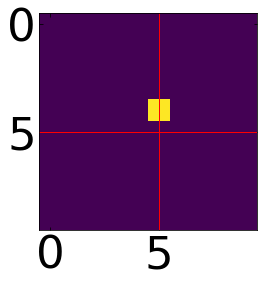

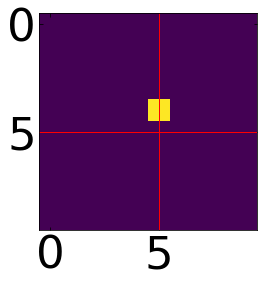

(4, 5)

In [488]:
im1 = np.zeros((10,10))
im2 = np.zeros((10,10))
im1[4,5] = 1
im2[4,4] = 1
plt.figure()
plt.imshow(im1)
plt.axvline(5,color='red')
plt.axhline(5,color='red')
plt.show()

plt.figure()
plt.imshow(convolve2d(im1,im2,mode='same'))
plt.axvline(5,color='red')
plt.axhline(5,color='red')
plt.show()
np.unravel_index(np.argmax(convolve2d(im1,im2,mode='same').flatten()),(10,10))

(40, 41)
255.0 251.0


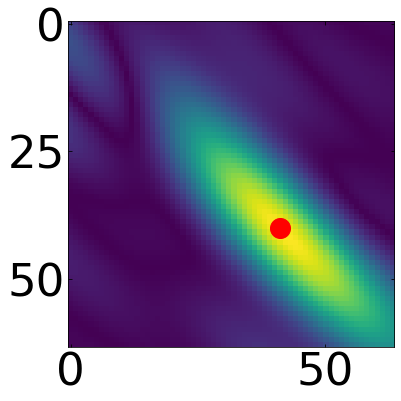

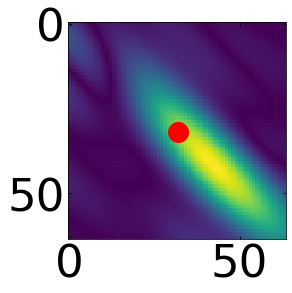

In [119]:
plt.figure(figsize=(6,6))
plt.imshow(PSFimg[:,:,500,0])

print(np.unravel_index(np.argmax(PSFimg[:,:,500,0]),(64,64)))
maxpix = np.unravel_index(np.argmax(PSFimg[:,:,500,0]),(64,64))
plt.plot(maxpix[1],maxpix[0],'o',color='red',markersize=20,zorder=1000)
print(PSFimg[40,41,500,0],PSFimg[41,40,500,0])

centerpix = (40,41)

plt.show()
plt.figure
rolledPSFimg = np.roll(np.roll(PSFimg[:,:,:,:],shift=centerpix[0]-maxpix[0],axis=0),shift=centerpix[1]-maxpix[1],axis=1)
rolledPSFimg[64 - (maxpix[0]-centerpix[0]):,:,:,:] = 0
rolledPSFimg[:,64 - (maxpix[1]-centerpix[1]):,:,:] = 0

plt.imshow(rolledPSFimg[:,:,500,0])
#plt.imshow(np.roll(PSFimg[:,:,500,0],shift=32-maxpix[1],axis=1))

plt.plot(32,32,'o',color='red',markersize=20,zorder=1000)
plt.show()

In [85]:
tuple(np.array(maxpix)-32)

(8, 9)

# we now have functions to (1) make test image cubes (2) make test psf that's a function of position and frequency (3) function to get S/N
# now need to re-implement search code

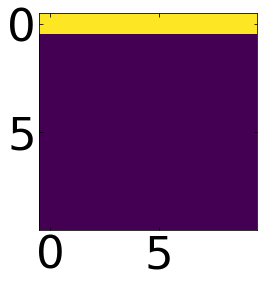

In [144]:
bb = np.zeros((10,10))
bb[5,:] = 1
plt.figure()
plt.imshow(np.roll(bb,shift=np.arange(10),axis=0))
plt.show()

In [155]:
sl.tsamp

130

In [172]:
def dedisperse(image_tesseract_point,DM,tsamp=sl.tsamp,freq_axis=sl.freq_axis):
    #get delay axis
    tdelays = DM*4.15*(((np.min(freq_axis)*1e-3)**(-2)) - ((freq_axis*1e-3)**(-2)))#(8.3*(chanbw)*burst_DMs[i]/((freq_axis*1e-3)**3))*(1e-3) #ms
    tdelays_idx_hi = np.array(np.ceil(tdelays/tsamp),dtype=int)
    tdelays_idx_low = np.array(np.floor(tdelays/tsamp),dtype=int)
    tdelays_frac = tdelays/tsamp - tdelays_idx_low

    nchans = len(freq_axis)
    dedisp_timeseries = np.zeros(image_tesseract_point.shape[0])
    #shift each channel
    for k in range(nchans):
        #print(tdelays_idx_hi,tdelays_idx_low,tdelays_frac)
        arrlow =  np.pad(image_tesseract_point[:,k],((0,tdelays_idx_low[k])),mode="constant",constant_values=0)[tdelays_idx_low[k]:]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)
        arrhi =  np.pad(image_tesseract_point[:,k],((0,tdelays_idx_hi[k])),mode="constant",constant_values=0)[tdelays_idx_hi[k]:]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)

        dedisp_timeseries += arrlow*(1-tdelays_frac[k]) + arrhi*(tdelays_frac[k])
    return dedisp_timeseries


def run_search_new(image_tesseract,RA_axis=sl.RA_axis,DEC_axis=sl.DEC_axis,time_axis=sl.time_axis,freq_axis=sl.freq_axis,
                   DM_trials=sl.DM_trials,widthtrials=sl.widthtrials,tsamp=sl.tsamp,SNRthresh=sl.SNRthresh,plot=False,
                   off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,output_file="",noiseth=3,canddict=dict()):

    """
    This function takes an image cube of shape npixels x npixels x nchannels x ntimes and runs a dedispersion search that returns
    a list of candidates' DM, pulse width, RA, declination, and time of arrival(?)
    """
    if output_file != "":
        fout = open(output_file,"a")
    else:
        fout = sys.stdout
    
    #get axis sizes
    gridsize = len(RA_axis)
    nsamps = len(time_axis)
    nchans = len(freq_axis)

    #dedisperse --> gridsize x gridsize x time x DM
    nDMtrials = len(DM_trials)
    print("Starting dedispersion with " + str(nDMtrials) + " trials",file=fout)
    image_tesseract_dedisp = np.zeros((gridsize,gridsize,nsamps,nDMtrials)) #stores output array as dedispersion transform for every pixel
    

    for i in range(gridsize):
        for j in range(gridsize):
            for d in range(nDMtrials):
                image_tesseract_dedisp[i,j,:,d] = dedisperse(image_tesseract[i,j,:,:],DM=DM_trials[d],tsamp=tsamp,freq_axis=freq_axis)
    
    #don't need frequency or time dependence for now...
    """if len(PSF.shape) == 4:
        PSF = PSF.mean(axis=(2,3))
    elif len(PSF.shape) == 3:
        PSF = PSF.mean(axis=2)
    """

    #2D matched filter for each timestep and channel
    image_tesseract_filtered = matched_filter_space(image_tesseract_dedisp,PSF)
    
    #boxcar filter and get snr using rolled PSF --> gridsize x gridsize x width x DM (x TOA?)
    nwidthtrials = len(widthtrials)
    image_tesseract_binned = np.zeros((gridsize,gridsize,nwidthtrials,nDMtrials)) #stores output array as S/N for each dedispersion and width trial for every pixel
    
    #PSF parameters
    maxs = []
    maxs2 = []
    for w in range(nwidthtrials):
        for d in range(nDMtrials):
            image_tesseract_binned[:,:,w,d] = snr_vs_RA_DEC_new(image_tesseract_filtered[:,:,:,d],widthtrials[w],noiseth=noiseth) 
            if d ==0:
                maxs.append(image_tesseract_binned[15, 16,w,d])
            else:
                maxs2.append(image_tesseract_binned[15, 16,w,d])
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(widthtrials,maxs,'o-')
        plt.plot(widthtrials,maxs2,'o-')
        plt.plot(np.arange(1,10),maxs[np.argmin(np.abs(widthtrials-5))]*np.sqrt(5/np.arange(1,10)),color='red')
        plt.plot(np.arange(1,10),maxs[np.argmin(np.abs(widthtrials-5))]*np.sqrt(np.arange(1,10)/5),color='blue')
        plt.show()
        


    
    #find candidates above SNR threshold
    condition = (image_tesseract_binned>SNRthresh).flatten()
    ncands = np.sum(condition)
    canddec_idxs,candra_idxs,candwid_idxs,canddm_idxs=np.unravel_index(np.arange(gridsize*gridsize*nDMtrials*nwidthtrials)[condition],(gridsize,gridsize,nwidthtrials,nDMtrials))#[1].shape
    
    canddecs = DEC_axis[canddec_idxs]
    candras = RA_axis[candra_idxs]
    candwids = widthtrials[candwid_idxs]
    canddms = DM_trials[canddm_idxs]
    candsnrs = imgsearched.flatten()[condition]
    
    candidxs = [(candra_idxs[i],canddec_idxs[i],candwid_idxs[i],canddm_idxs[i],candsnrs[i]) for i in range(ncands)]
    cands = [(candras[i],canddecs[i],candwids[i],canddms[i],candsnrs[i]) for i in range(ncands)]

    #make a dictionary for easy plotting of results
    canddict['ra_idxs'] = copy.deepcopy(candra_idxs)
    canddict['dec_idxs'] = copy.deepcopy(canddec_idxs)
    canddict['wid_idxs'] = copy.deepcopy(candwid_idxs)
    canddict['dm_idxs'] = copy.deepcopy(canddm_idxs)
    canddict['ras'] = copy.deepcopy(candras)
    canddict['decs'] = copy.deepcopy(canddecs)
    canddict['wids'] = copy.deepcopy(candwids)
    canddict['dms'] = copy.deepcopy(canddms)
    canddict['snrs'] = copy.deepcopy(candsnrs)
    
    return candidxs,cands,image_tesseract_binned,image_tesseract_filtered


    

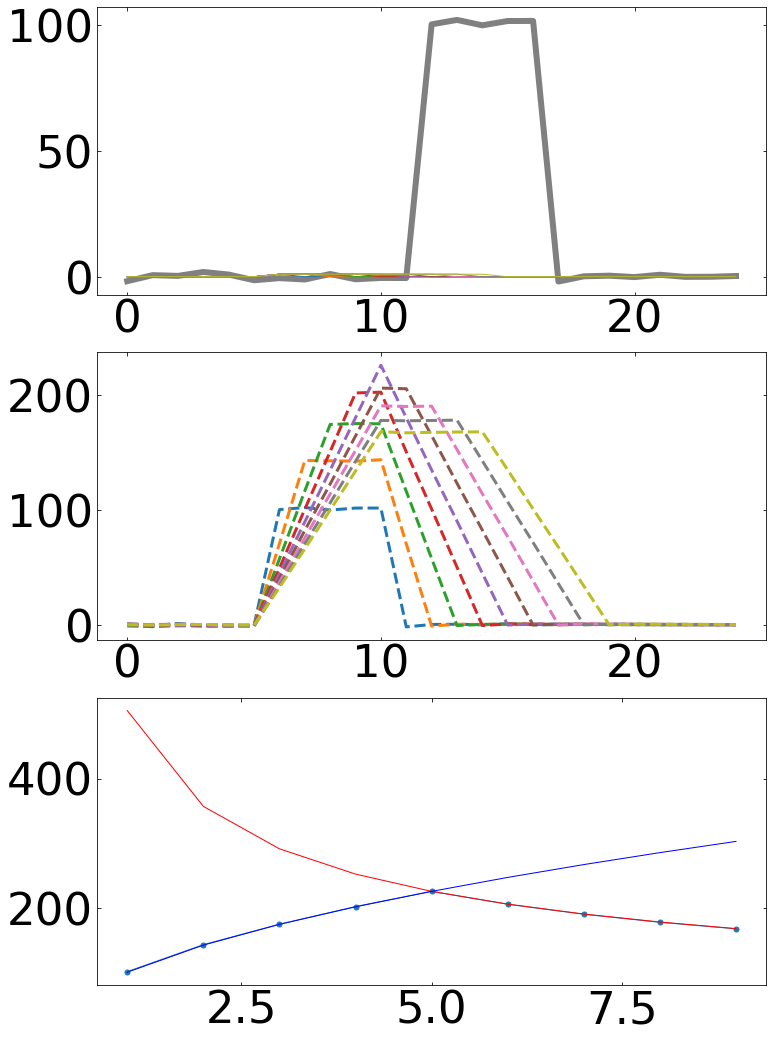

In [123]:
testpulse = np.zeros(25)
testpulse[25//2:(25//2) + 5] = 1
snr = 100

testpulse += norm.rvs(loc=0,scale=1/snr,size=25)
testpulse = testpulse*snr

plt.figure(figsize=(12,18))
plt.subplot(3,1,1)
plt.plot(testpulse,color='grey',linewidth=6)
maxs = []
for i in np.arange(1,10):

    #estimate binned off pulse noise
    offpnoise = np.sqrt(i)*1
    
    plt.subplot(3,1,1)
    testfilt = np.zeros(25)
    testfilt[25//4:(25//4) + i] = 1
    c=plt.plot(testfilt)

    
    plt.subplot(3,1,2)
    csig = np.convolve(testpulse,testfilt,mode='same')
    plt.plot(csig/offpnoise,color=c[0].get_color(),linestyle='--',linewidth=3)
    maxs.append(np.max(csig/offpnoise))

plt.subplot(3,1,3)
plt.plot(np.arange(1,10),maxs,'o-')
#plot theoretical curve
plt.plot(np.arange(1,10),maxs[4]*np.sqrt(5/np.arange(1,10)),color='red')
plt.plot(np.arange(1,10),maxs[4]*np.sqrt(np.arange(1,10)/5),color='blue')



plt.show()

Starting dedispersion with 2 trials


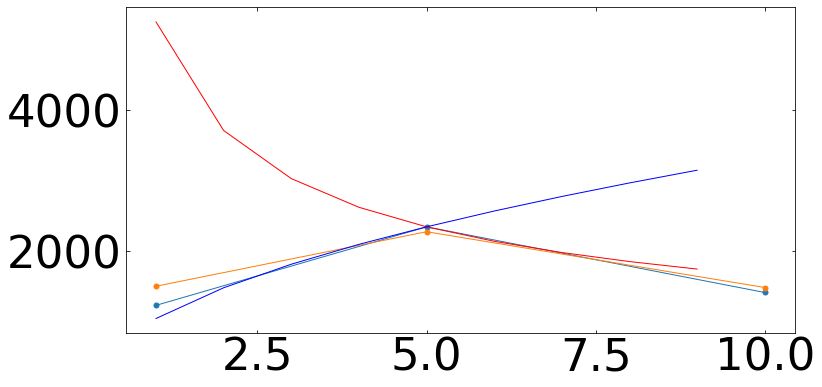

In [173]:
canddict=dict()
candidxs,cands,imgsearched,imgbinned=run_search_new(img,RA_axis=np.arange(32),DEC_axis=np.arange(32),time_axis=np.arange(75)*sl.tsamp,freq_axis=sl.freq_axis,
                   DM_trials=np.array([0,100]),widthtrials=np.array([1,5,10]),tsamp=sl.tsamp,SNRthresh=2000,plot=True,
                   off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,output_file="",noiseth=3,canddict=canddict)

In [1]:
def search_plots_new(canddict,RA_axis=sl.RA_axis,DEC_axis=sl.DEC_axis,DM_trials=sl.DM_trials,widthtrials=sl.widthtrials,output_dir=sl.output_dir):
    """
    Makes updated diagnostic plots for search system
    """
    gridsize = len(RA_axis)
    decs,ras,wids,dms=canddict['dec_idxs'],canddict['ra_idxs'],canddict['wid_idxs'],canddict['dm_idxs']#np.unravel_index(np.arange(32*32*2*3)[(imgsearched>2500).flatten()],(32,32,3,2))#[1].shape
    snrs = canddict['snrs']#imgsearched.flatten()[(imgsearched>2500).flatten()]


    
    plt.figure(figsize=(32,12))
    plt.subplot(1,2,1)
    plt.scatter(ras,decs,c=snrs,marker='o',s=snrs/10,cmap='jet',alpha=(snrs-np.min(snrs))/(2*np.max(snrs)-np.min(snrs)))
    plt.contour(img.mean((2,3)),levels=3,colors='purple',linewidths=4)
    plt.imshow(img.mean((2,3)),cmap='pink_r',aspect='auto')
    plt.axvline(gridsize//2,color='grey')
    plt.axhline(gridsize//2,color='grey')
    plt.xlabel("RA index")
    plt.ylabel("DEC index")
    
    plt.subplot(1,2,2)
    plt.scatter(widthtrials[wids],
                DM_trials[dms],c=snrs,marker='o',s=snrs,cmap='jet',alpha=(snrs-np.min(snrs))/(2*np.max(snrs)-np.min(snrs)))
    plt.colorbar(label='S/N')
    for i in widthtrials:
        plt.axvline(i,color='grey',linestyle='--')
    for i in DM_trials:
        plt.axhline(i,color='grey',linestyle='--')
    plt.xlim(0,np.max(widthtrials)*2)
    plt.ylim(0,np.max(DM_trials)*10)
    plt.xlabel("Width (Samples)")
    plt.ylabel("DM (pc/cc)")
    plt.savefig(output_dir + "diagnostic_RA_DEC.png")
    plt.show()


NameError: name 'sl' is not defined

Starting dedispersion with 2 trials...
Done!
Spatial matched filtering with DSA PSF...
Done!
Starting boxcar filtering with 3 trials...
Done!


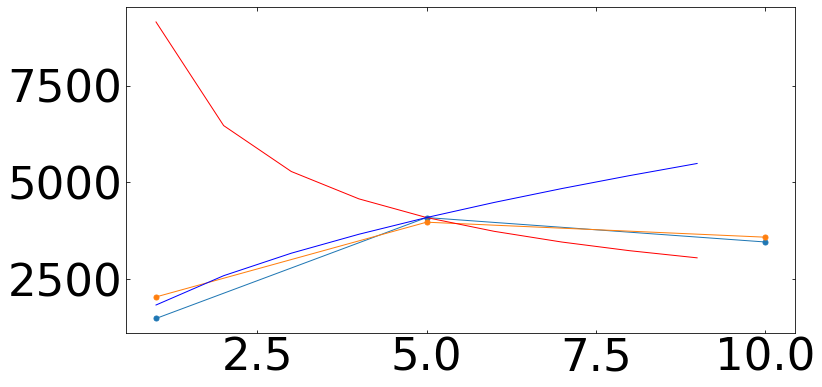

Searching for candidates with S/N > 2000...
Done! Found 467 candidates


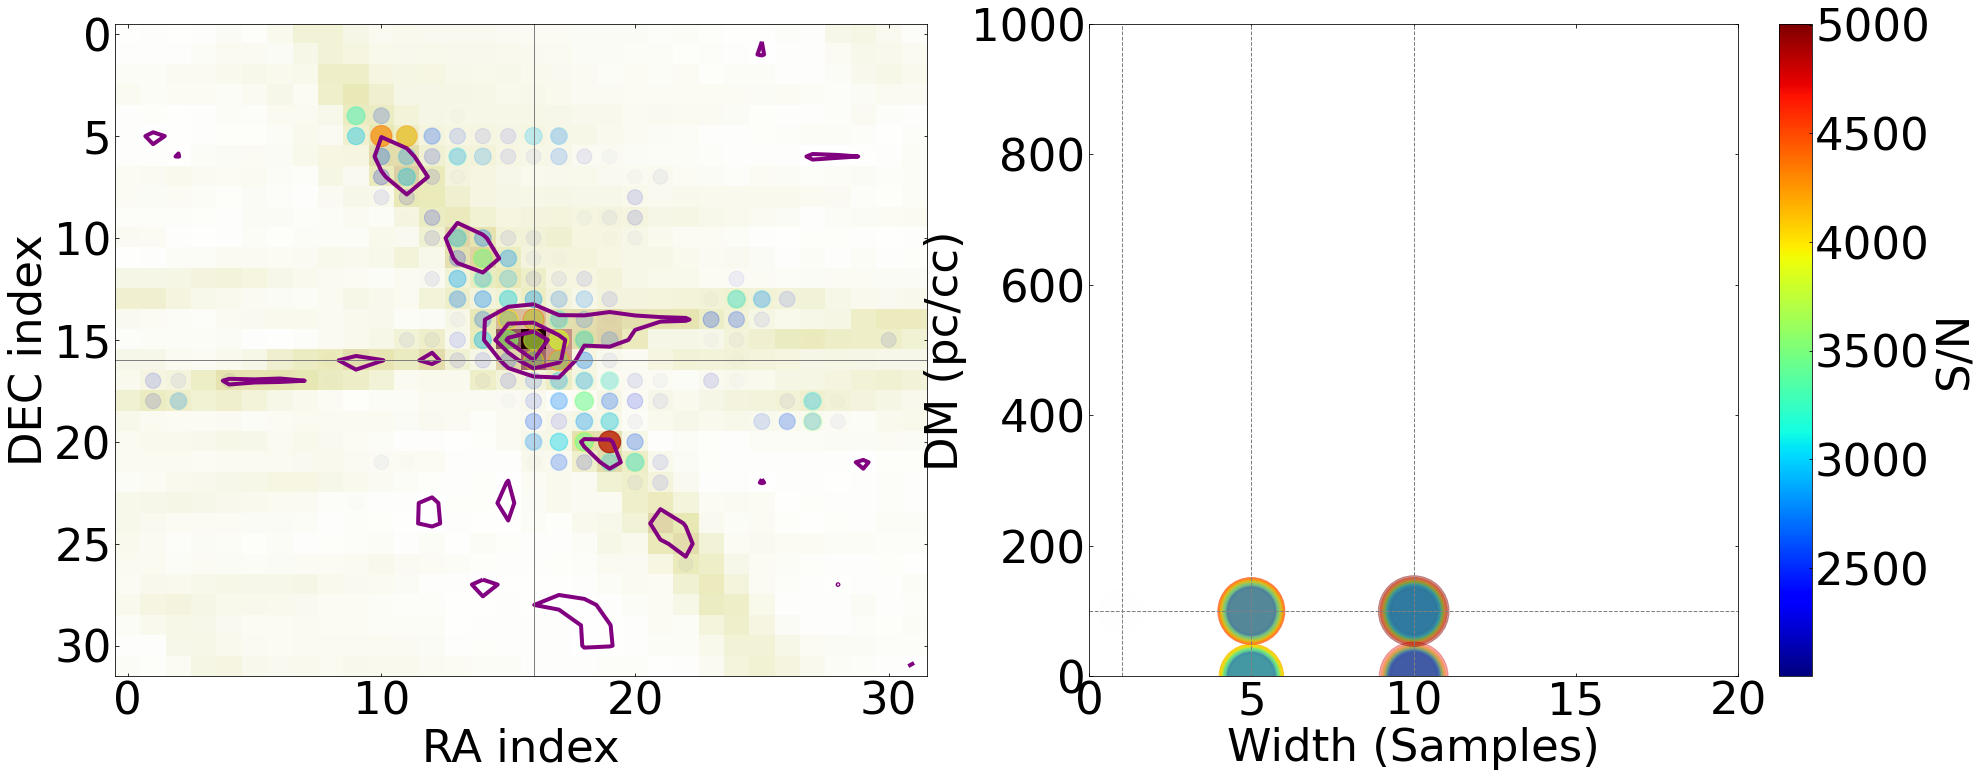

In [3]:
canddict = dict()
candidxs,cands,imgsearched,imgbinned=sl.run_search_new(img,RA_axis=np.arange(32),DEC_axis=np.arange(32),time_axis=np.arange(75)*sl.tsamp,freq_axis=sl.freq_axis,
                   DM_trials=np.array([0,100]),widthtrials=np.array([1,5,10]),tsamp=sl.tsamp,SNRthresh=2000,plot=True,
                   off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,output_file="",noiseth=3,canddict=canddict)
sl.search_plots_new(canddict,img,RA_axis=np.arange(32),DEC_axis=np.arange(32),DM_trials=np.array([0,100]),widthtrials=np.array([1,5,10]))

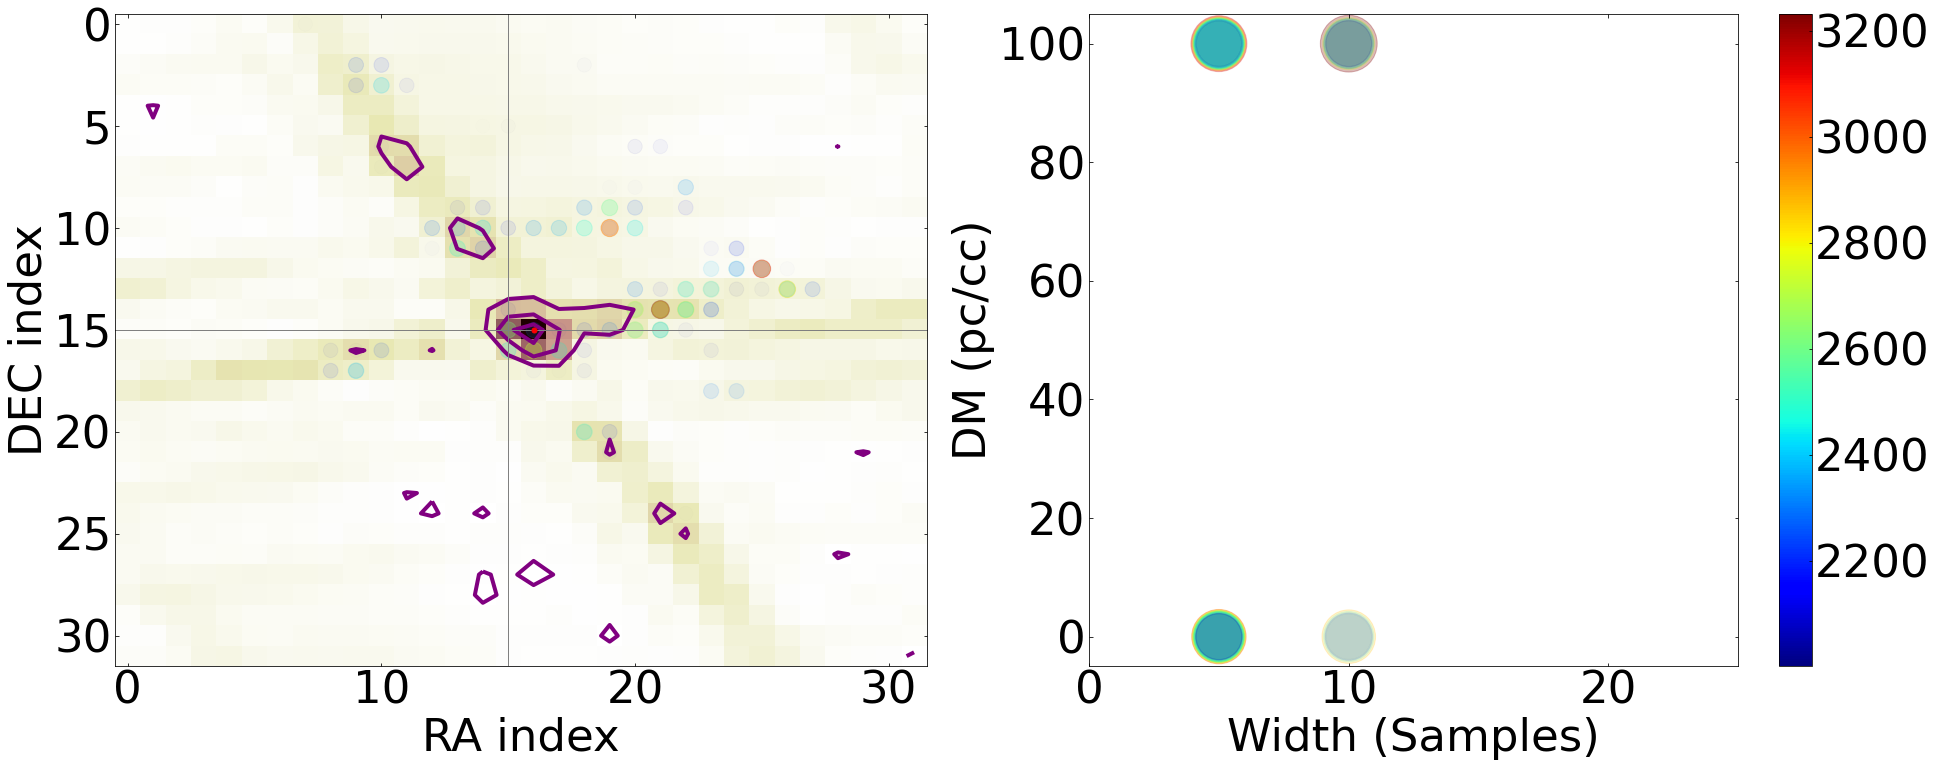

In [177]:
decs,ras,wids,dms=canddict['dec_idxs'],canddict['ra_idxs'],canddict['wid_idxs'],canddict['dm_idxs']#np.unravel_index(np.arange(32*32*2*3)[(imgsearched>2500).flatten()],(32,32,3,2))#[1].shape
snrs = canddict['snrs']#imgsearched.flatten()[(imgsearched>2500).flatten()]

plt.figure(figsize=(32,12))
plt.subplot(1,2,1)
plt.scatter(ras,decs,c=snrs,marker='o',s=snrs/10,cmap='jet',alpha=(snrs-np.min(snrs))/(2*np.max(snrs)-np.min(snrs)))
plt.contour(img[:,:,75//2,:].mean(2),levels=3,colors='purple',linewidths=4)
plt.imshow(img[:,:,75//2,:].mean(2),cmap='pink_r',aspect='auto')
plt.axvline(15,color='grey')
plt.axhline(15,color='grey')
plt.xlabel("RA index")
plt.ylabel("DEC index")
plt.plot(16,15,color='red',marker='o',)

plt.subplot(1,2,2)
plt.scatter(np.array([1,5,10])[wids],
            np.array([0,100])[dms],c=snrs,marker='o',s=snrs,cmap='jet',alpha=(snrs-np.min(snrs))/(2*np.max(snrs)-np.min(snrs)))
#plt.contour(img[:,:,25//2,:].mean(2),levels=3,colors='red',linewidths=4)
#plt.imshow(img[:,:,25//2,:].mean(2),cmap='pink_r')
#plt.axvline(15,color='white')
#plt.axhline(15,color='white')
plt.colorbar()
plt.xlim(0,25)
#plt.yscale("log")
plt.xlabel("Width (Samples)")
plt.ylabel("DM (pc/cc)")
plt.show()

In [20]:
img[15,16,:,0].sum(),np.unravel_index(np.argmax(img.mean((2,3))),(32,32))

(0.4460701093803844, (15, 16))

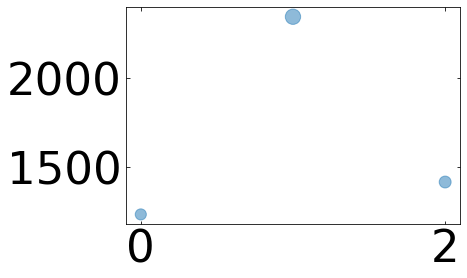

In [138]:
plt.scatter(wids[np.logical_and(dms==0,np.logical_and(ras==16,decs==15))],
         snrs[np.logical_and(dms==0,np.logical_and(ras==16,decs==15))],marker='o',
         s=snrs[np.logical_and(dms==0,np.logical_and(ras==16,decs==15))]/10,alpha=0.5)

#plt.ylim(153,155)

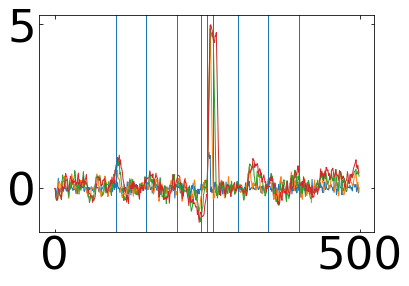

[1.1042697269864234, 4.955880868497393, 4.861884549553291, 4.982710786884156]
[0.1509136392742325, 0.48518211139243217, 0.7218390030805637, 0.8973344836821736]
[ 7.31722946 10.21447566  6.73541403  5.55279094]


In [699]:
x1 = np.zeros(500)
x1[250:255] = 1
x1 += norm.rvs(loc=0,scale=0.1,size=500)
plt.figure()
maxx = []
noisx = []
for i in [1,5,10,15]:
    x2 = np.zeros(500)
    x2[250:250+i] = 1
    xbin = np.convolve(x1,x2,mode='same')
    maxx.append(np.max(xbin))
    noisx.append(np.std(xbin[100:]))
    plt.plot(xbin)

plt.axvline(250)
#plt.xlim(200,300)
plt.show()
print(maxx)
print(noisx)
print(np.array(maxx)/np.array(noisx))

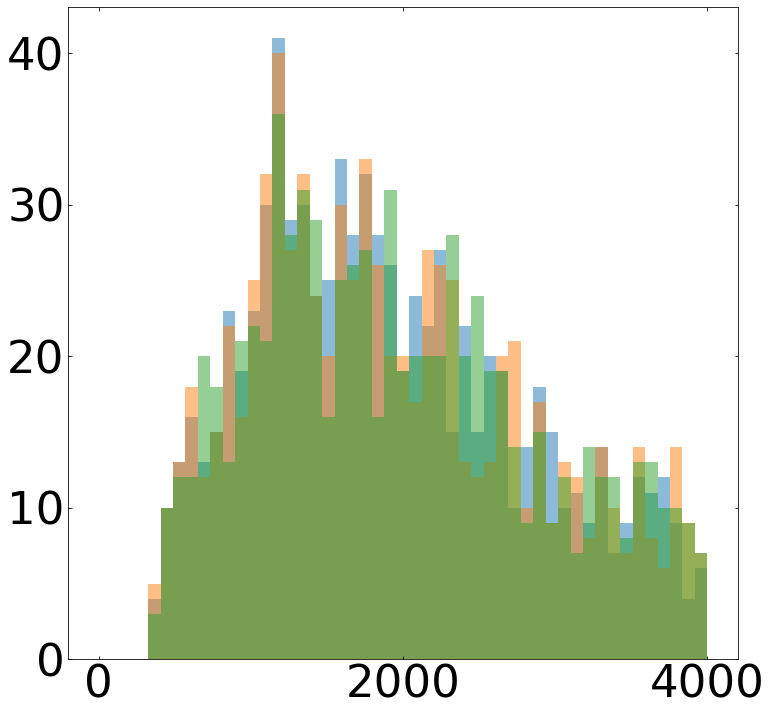

In [539]:
plt.figure(figsize=(12,12))
for d in range(3):
    #print(imgsearched[:,:,0,d])
    plt.hist(imgsearched[:,:,2,d].flatten(),np.linspace(0,4000),alpha=0.5,)
plt.show()

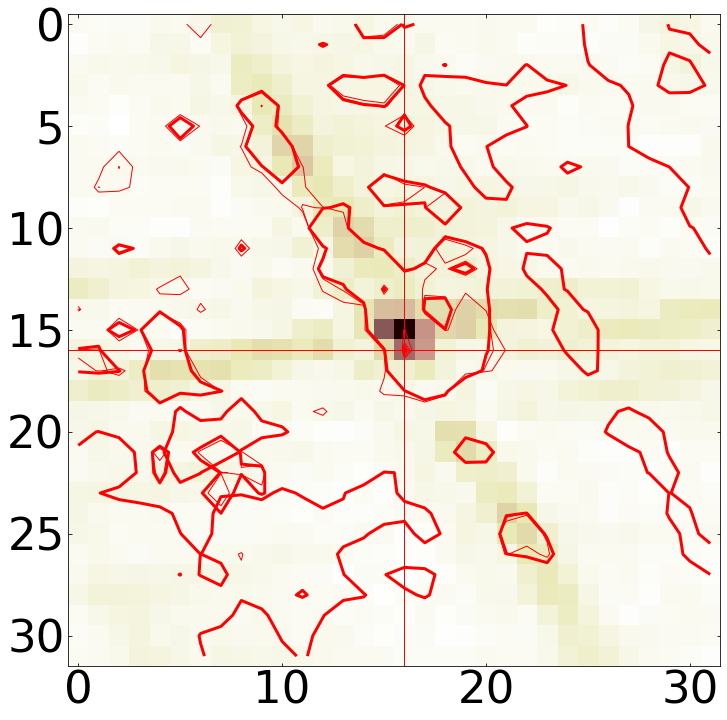

In [534]:
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,25//2,0],cmap='pink_r')
#plt.contour(img[:,:,25//2,0],levels=3,colors='pink',linewidths=4)
#plt.contour(PSFimg[:,:,25//2,0],levels=3,colors='orange',linewidths=1)
for d in range(4):
    plt.contour(imgsearched[:,:,0,d],levels=1,colors='red',linewidths=5-2*(d+1))
plt.axvline(16,color='red')
plt.axhline(16,color='red')
plt.show()


ValueError: s must be a scalar, or float array-like with the same size as x and y

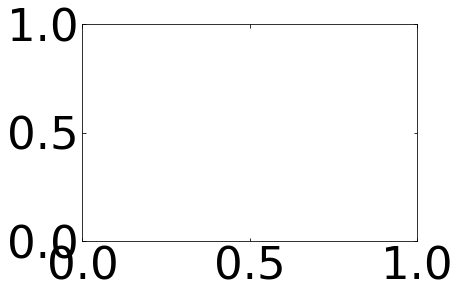

In [211]:
wids,dms = np.meshgrid([0,100,1000],[2])
ras,decs = np.meshgrid(np.arange(32),np.arange(32))
wids,dms
for i in range(32):
    for j in range(32):
        plt.scatter(wids.flatten(),dms.flatten(),c=imgsearched[i,j,:,:].flatten(),alpha=0.2,cmap='jet',s=imgsearched[i,j,:,:]*10)

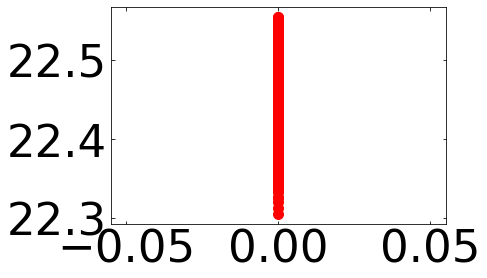

In [189]:
wids,dms = np.meshgrid([0,100,1000],[1,2])
for k in range(3):
    for f in range(2):
        plt.(imgsearched[i,j,f,k],color='red',markersize=10,marker='o')

(array([  5.,  59., 372., 498., 452., 583., 445., 341., 218.,  99.]),
 array([22.3046805 , 22.32972759, 22.35477468, 22.37982177, 22.40486886,
        22.42991596, 22.45496305, 22.48001014, 22.50505723, 22.53010432,
        22.55515142]),
 <BarContainer object of 10 artists>)

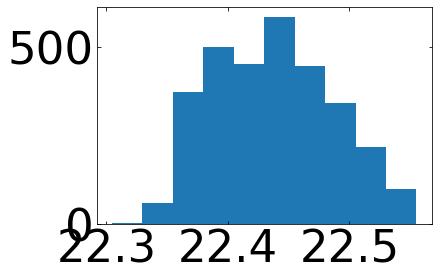

In [199]:
plt.hist(imgsearched.flatten())

# Testing time requirement for convolution

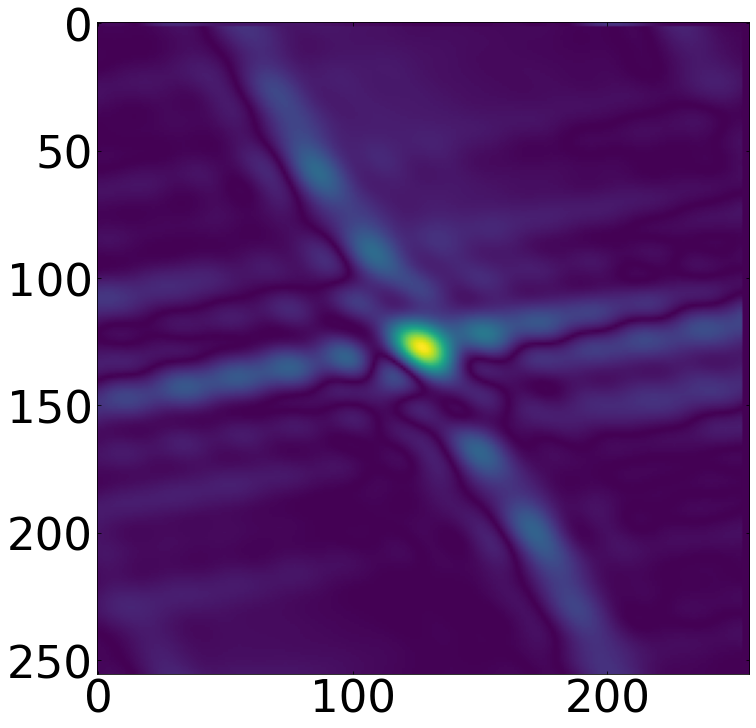

subband_avg_1311.39_MHz.png
subband_avg_1440.29_MHz.png
subband_avg_1323.11_MHz.png
subband_avg_1452.01_MHz.png
subband_avg_1334.82_MHz.png
subband_avg_1428.57_MHz.png
subband_avg_1416.86_MHz.png
subband_avg_1393.42_MHz.png
subband_avg_1346.54_MHz.png
subband_avg_1405.14_MHz.png
subband_avg_1381.70_MHz.png
subband_avg_1463.73_MHz.png
subband_avg_1475.45_MHz.png
subband_avg_1487.17_MHz.png
subband_avg_1369.98_MHz.png
subband_avg_1358.26_MHz.png
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(2

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

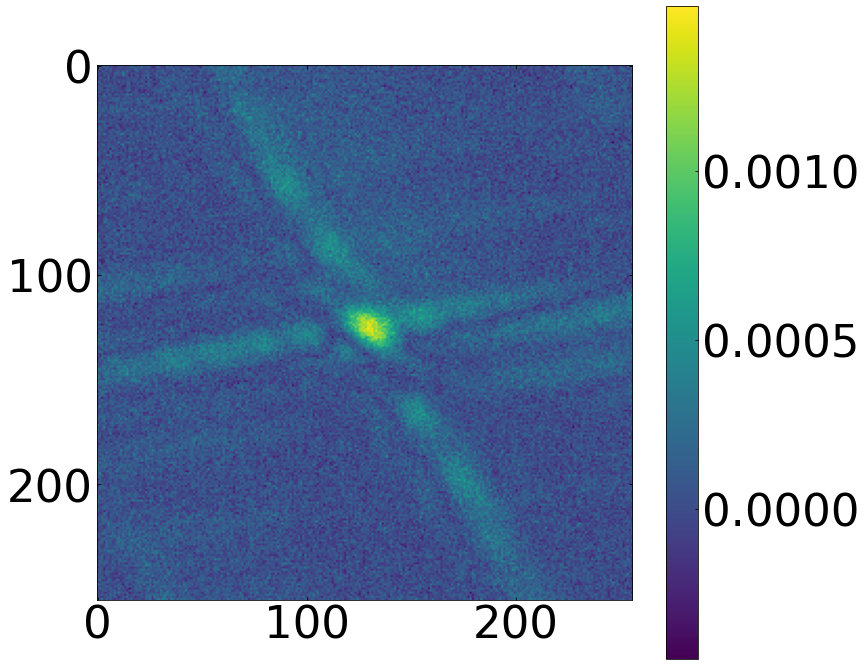

In [1]:
from scipy.signal import convolve2d
import time
import sys
sys.path.append("/dataz/dsa110/imaging/dsa110-nsfrb/")
import nsfrb.searching as sl
from PIL import Image,ImageOps
import numpy as np
from scipy.stats import norm
import os
import copy
from matplotlib import pyplot as plt
from simulations_and_classifications import generate_source_images as gsi
"""p1 = np.zeros((300,300))
p2 = np.zeros((300,300))
t1 = time.time()
for i in range(16):
    for j in range(4):
        convolve2d(p1,p2,mode='same')
print(time.time()-t1)"""


plt.figure(figsize=(12,12))
PSFimg = sl.make_PSF_cube(gridsize=256,nsamps=75)
plt.imshow(PSFimg[:,:,75//2,0])
plt.show()

import copy 
img = sl.make_image_cube(PSFimg=PSFimg,snr=1000,gridsize=256,nsamps=75,DM=0)

#print(get_SNR(img,PSFimg,5,loc=25//2))#,noises=noises))
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,75//2,0])
plt.colorbar()
plt.show()

In [4]:
tmp,imgd = sl.dedisperse(img,DM=-1000)

Trial DM: 1000 pc/cc, DM delays (ms): [  0.          64.69615238 126.94491547 186.86819349 244.58039404
 300.18897463 353.79494321 405.49331717 455.37354472 503.519892
 550.01179926 594.92420871 638.32786677 680.28960277 720.87258642
 760.13656565]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (1, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (1, 0))
((0, 0), (0, 0), (1, 0))
((0, 0), (0, 0), (2, 0))
((0, 0), (0, 0), (1, 0))
((0, 0), (0, 0), (2, 0))
((0, 0), (0, 0), (2, 0))
((0, 0), (0, 0), (3, 0))
((0, 0), (0, 0), (2, 0))
((0, 0), (0, 0), (3, 0))
((0, 0), (0, 0), (3, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (3, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (3, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (6, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (6, 0))

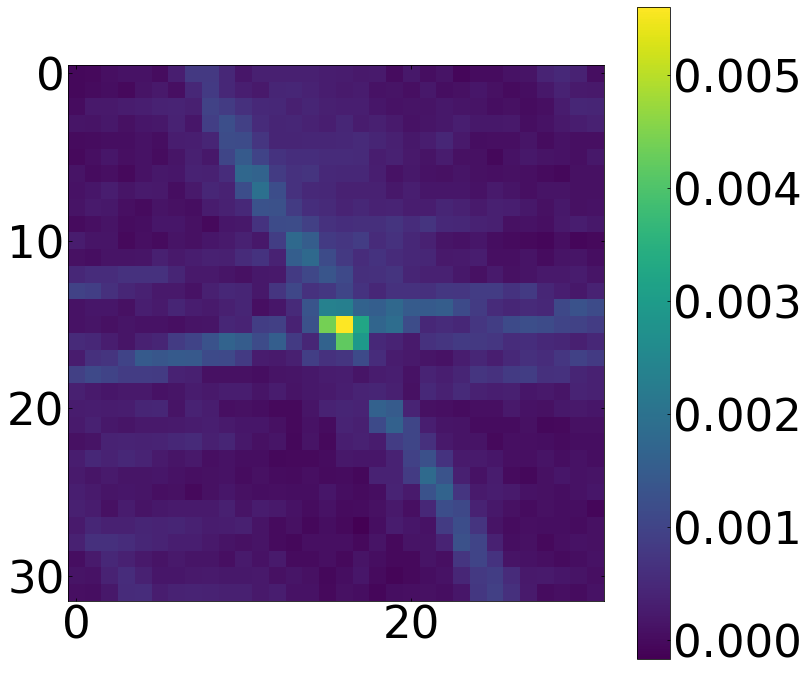

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(imgd[:,:,75//2,0])
plt.colorbar()
plt.show()

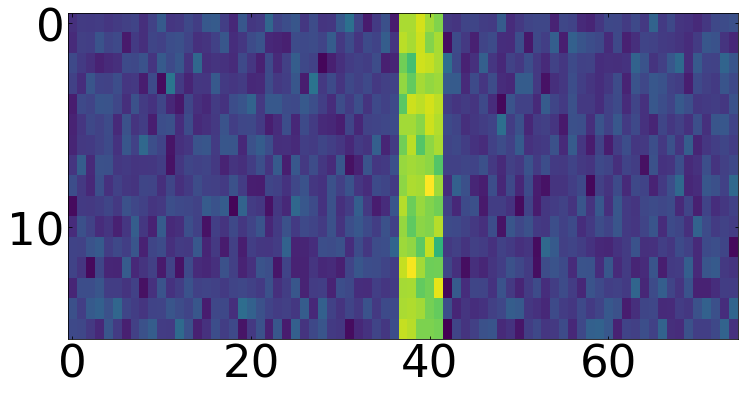

In [18]:
plt.figure(figsize=(12,6))
plt.imshow(img[128,128,:,:].transpose(),aspect='auto')
plt.show()

In [17]:
t1 = time.time()
canddict = dict()
dmt = np.array([0,100,1000])#np.array(sl.gen_dm(sl.minDM,sl.maxDM,1.5,sl.fc*1e-3,sl.nchans,sl.tsamp,sl.chanbw))
wt = np.array([1])
gsize = 256
candidxs,cands,imgsearched,imgbinned,d,tmp,tmp,tmp,tmp=sl.run_search_new(img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),
                                                       time_axis=np.arange(75)*sl.tsamp,freq_axis=sl.freq_axis,
                                                       DM_trials=dmt,widthtrials=wt,
                                                       tsamp=sl.tsamp,SNRthresh=1500,plot=False,
                                                       off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,
                                                       output_file="",noiseth=1e-2,canddict=canddict,
                                                       usefft=True,space_filter=True,multithreading=False,
                                                       nrows=2,ncols=4,samenoise=False)
print("FINAL TIME: ",time.time()-t1)

[000]Spatial matched filtering with DSA PSF...
[000]Using 2D FFT method...
[000]Done!
[000]---> 0
[000]Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 

In [18]:
ndat2 = np.load("noisestats.npy")

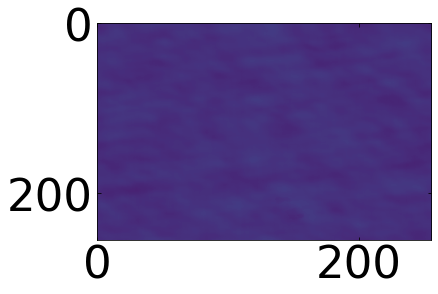

0.31820767910257813

In [19]:
plt.figure()
plt.imshow(ndat2,aspect='auto',vmin=0,vmax=1)
plt.show()
np.std(ndat.flatten())/np.mean(ndat.flatten())

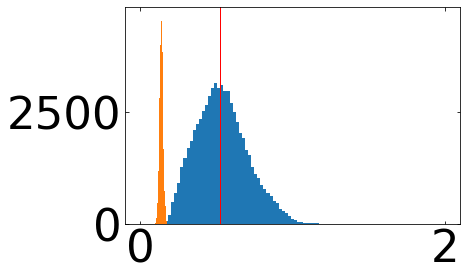

In [21]:
plt.figure()
plt.hist(ndat.flatten(),np.linspace(0,2,100))
plt.hist(ndat2.flatten(),np.linspace(0,0.2,100))
plt.axvline(np.nanmedian(ndat.flatten()),color='red')
plt.show()

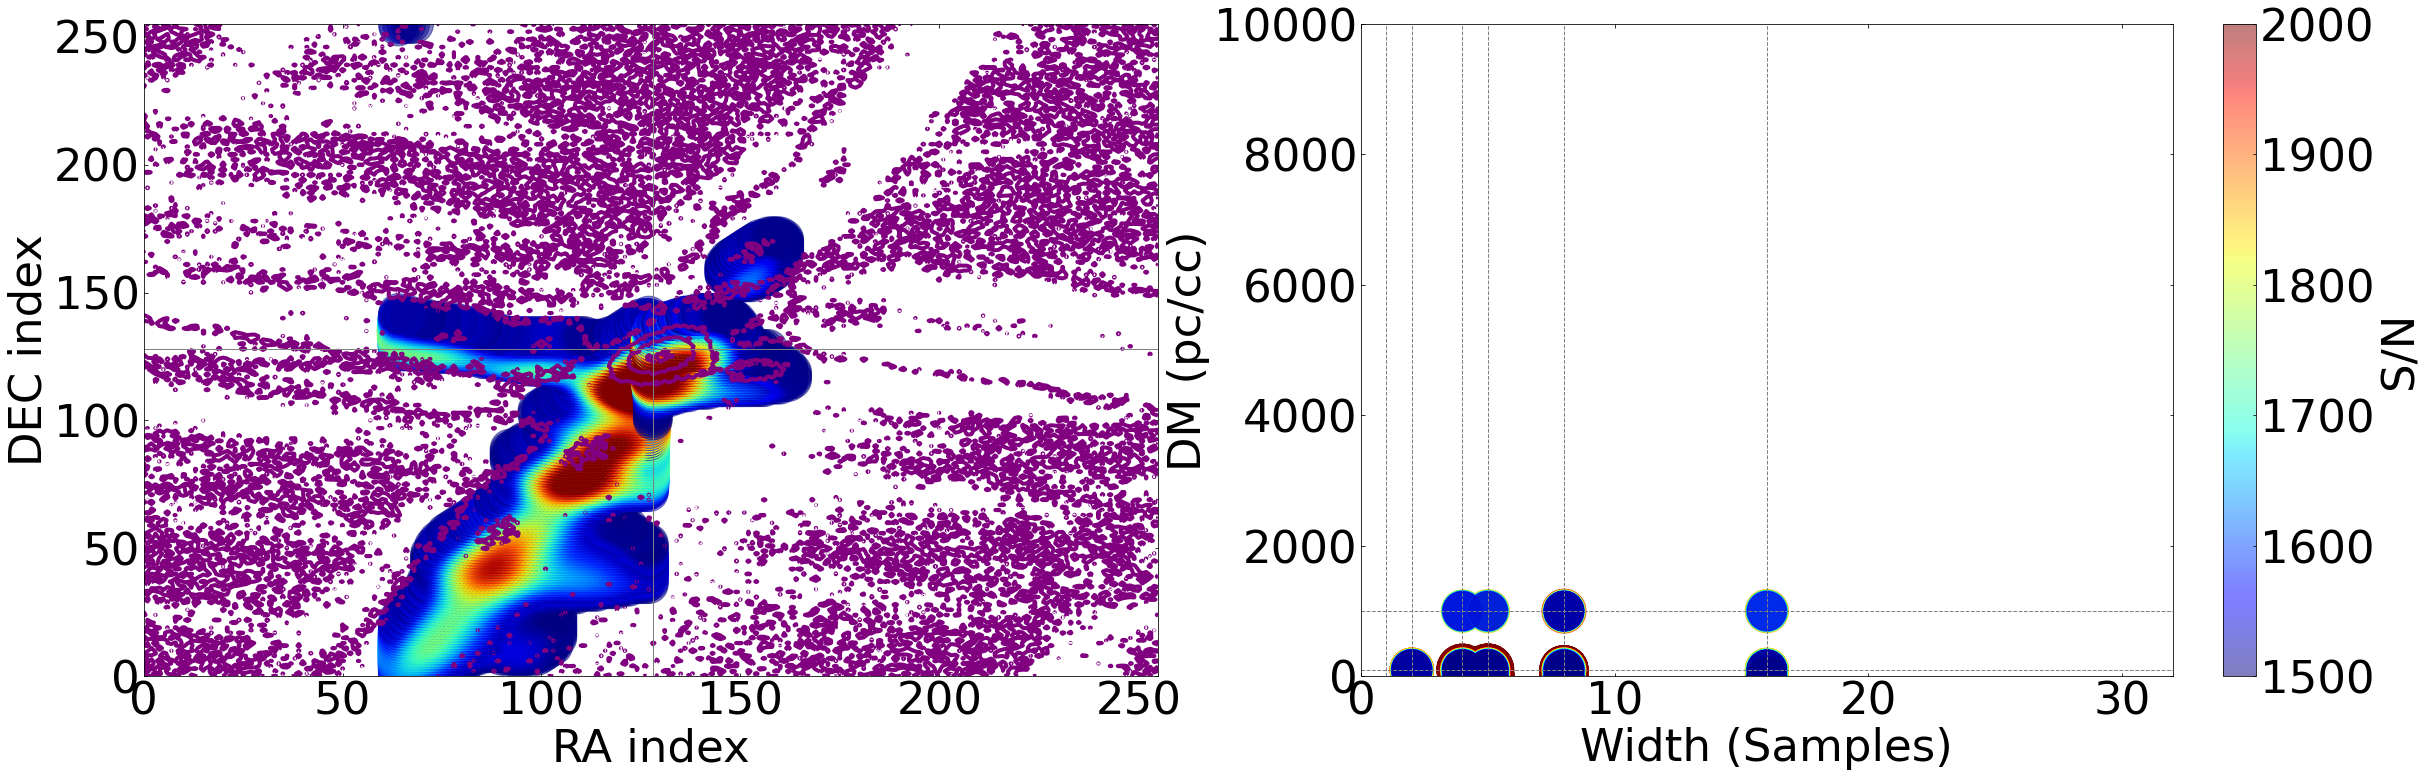

In [3]:
from nsfrb import plotting as nplt
nplt.search_plots_new(canddict,img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),DM_trials=dmt,
                      widthtrials=wt,vmin=1500,vmax=2000,s100=100,
                      output_dir='/dataz/dsa110/imaging/dsa110-nsfrb/candidates/')

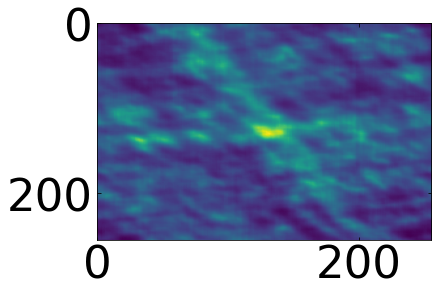

In [13]:
plt.imshow(imgsearched[:,:,0,0],aspect='auto')

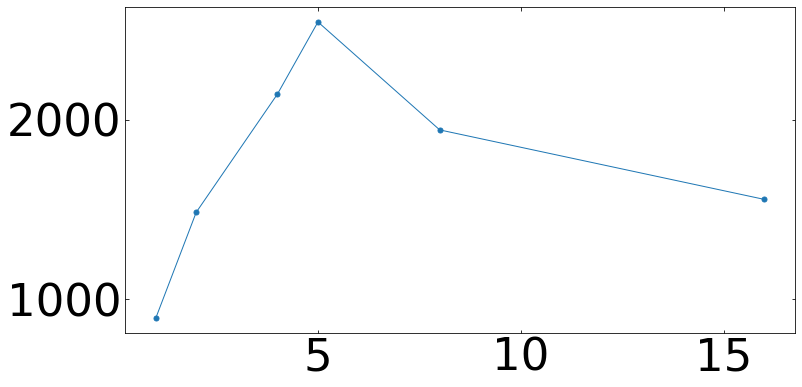

In [15]:
plt.figure(figsize=(12,6))
plt.plot(wt,imgsearched[128,128,:,0],'o-')
plt.show()

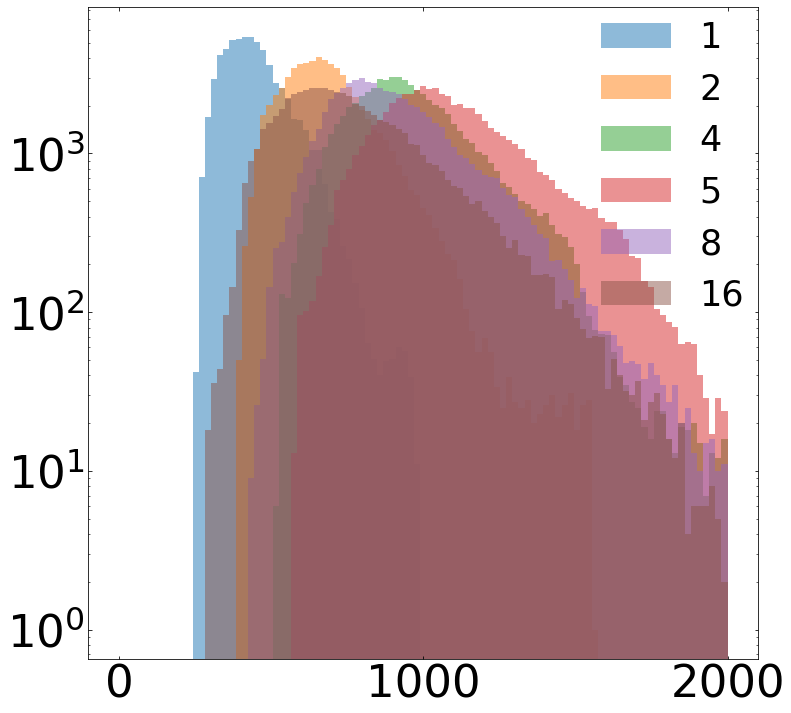

In [20]:
plt.figure(figsize=(12,12))
for i in range(len(wt)):
    plt.hist(imgsearched[:,:,i,0].flatten(),np.linspace(0,2000,100),alpha=0.5,label=wt[i])
    #plt.hist(imgsearched[:,:,1,0].flatten(),np.linspace(0,2000,100),alpha=0.5)
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()

# multithreading implementation

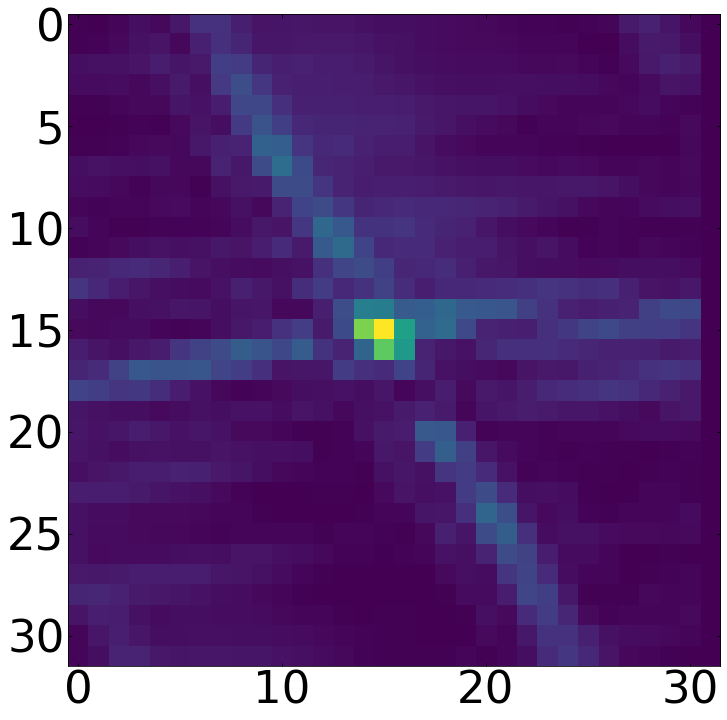

subband_avg_1311.39_MHz.png
subband_avg_1440.29_MHz.png
subband_avg_1323.11_MHz.png
subband_avg_1452.01_MHz.png
subband_avg_1334.82_MHz.png
subband_avg_1428.57_MHz.png
subband_avg_1416.86_MHz.png
subband_avg_1393.42_MHz.png
subband_avg_1346.54_MHz.png
subband_avg_1405.14_MHz.png
subband_avg_1381.70_MHz.png
subband_avg_1463.73_MHz.png
subband_avg_1475.45_MHz.png
subband_avg_1487.17_MHz.png
subband_avg_1369.98_MHz.png
subband_avg_1358.26_MHz.png
Downsampling by factor 8...(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 25

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

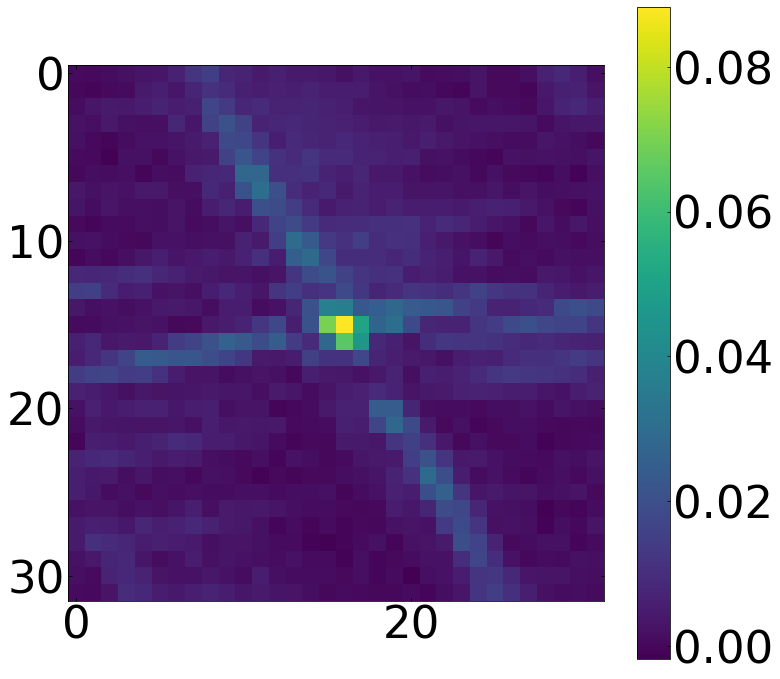

In [1]:
from scipy.signal import convolve2d
import time
import sys
sys.path.append("/dataz/dsa110/imaging/dsa110-nsfrb/")
import nsfrb.searching as sl
from PIL import Image,ImageOps
import numpy as np
from scipy.stats import norm
import os
import copy
from matplotlib import pyplot as plt
from simulations_and_classifications import generate_source_images as gsi
"""p1 = np.zeros((300,300))
p2 = np.zeros((300,300))
t1 = time.time()
for i in range(16):
    for j in range(4):
        convolve2d(p1,p2,mode='same')
print(time.time()-t1)"""


plt.figure(figsize=(12,12))
PSFimg = sl.make_PSF_cube(gridsize=32,nsamps=75)
plt.imshow(PSFimg[:,:,75//2,0])
plt.show()

import copy 
img = sl.make_image_cube(PSFimg=PSFimg,snr=1000,gridsize=32,nsamps=75,DM=0)

#print(get_SNR(img,PSFimg,5,loc=25//2))#,noises=noises))
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,75//2,0])
plt.colorbar()
plt.show()

Spatial matched filtering with DSA PSF...
Done!
---> 0
Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
Done!
Trial DM: 100

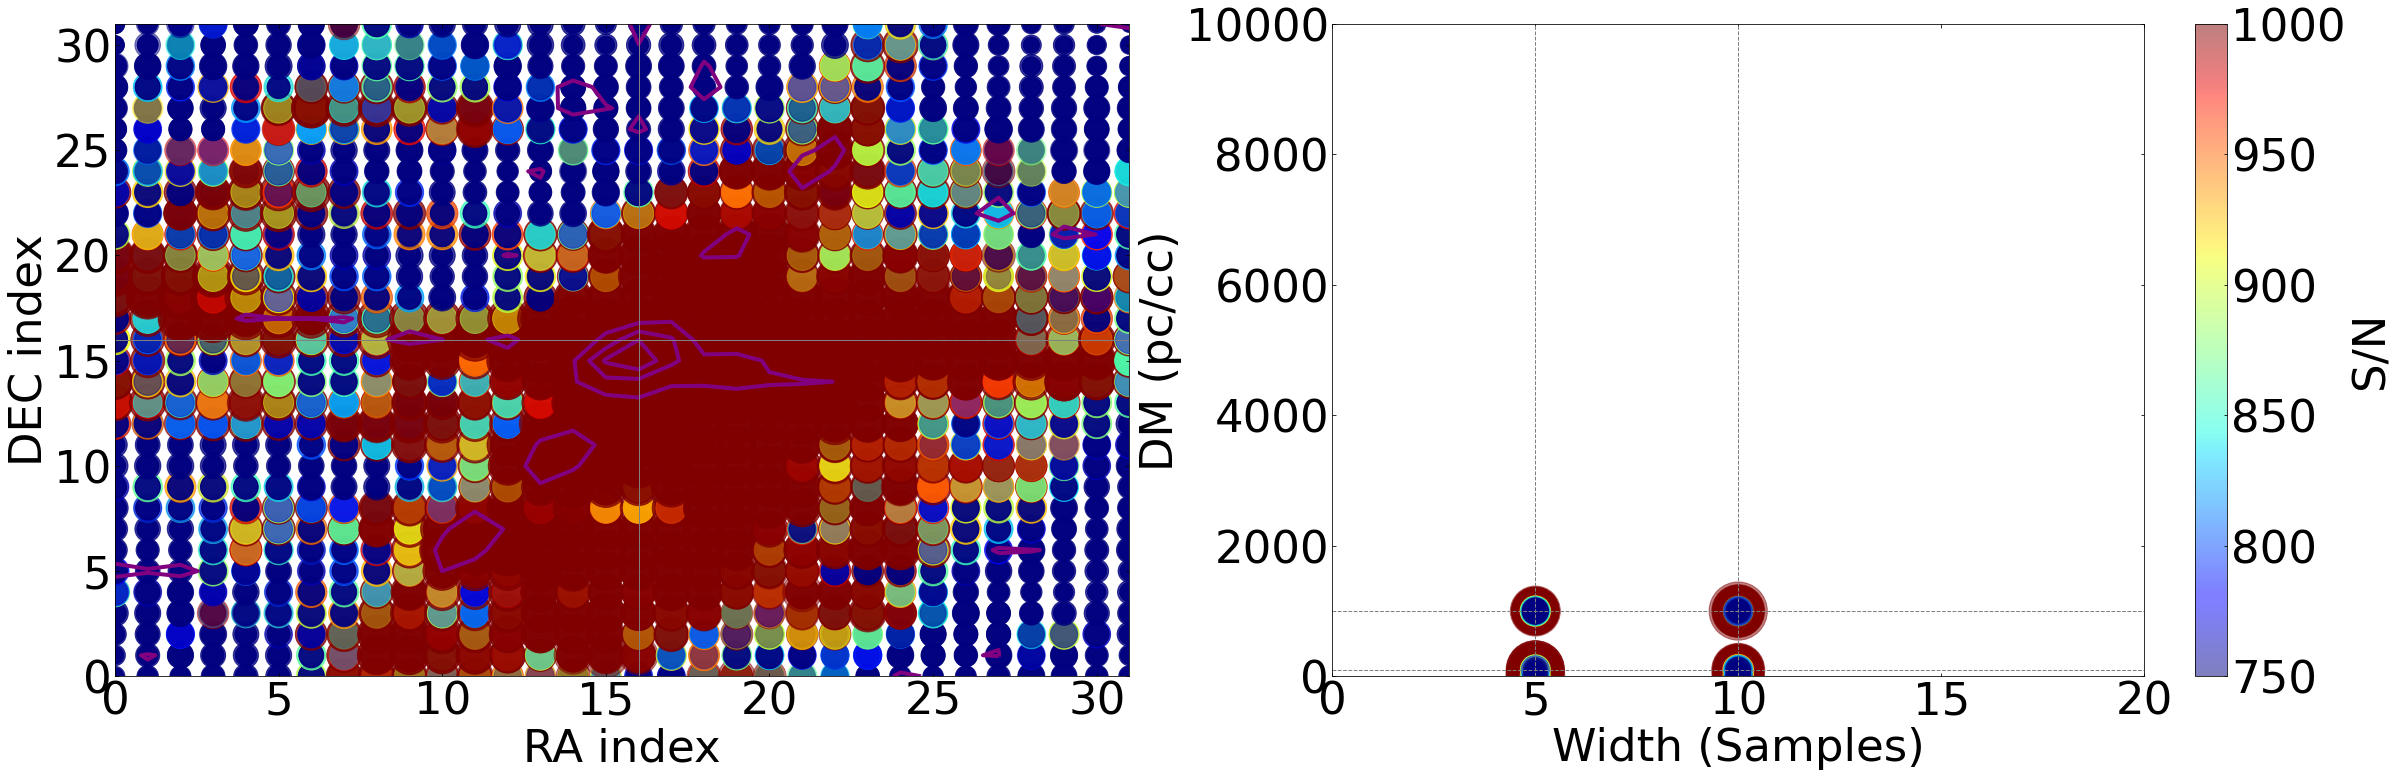

In [4]:
import time
t1 = time.time()
canddict = dict()
dmt = np.array([0,100,1000])#np.array(sl.gen_dm(sl.minDM,sl.maxDM,1.5,sl.fc*1e-3,sl.nchans,sl.tsamp,sl.chanbw))
wt = np.array([5,10])
gsize = 32

ts = []
candidxs,cands,imgsearched,imgbinned,canddict,tmp=sl.run_search_new(img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),
                                                       time_axis=np.arange(75)*sl.tsamp,freq_axis=sl.freq_axis,
                                                       DM_trials=dmt,widthtrials=np.array([5,10]),
                                                       tsamp=sl.tsamp,SNRthresh=0,plot=False,
                                                       off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,
                                                       output_file="",noiseth=1e-2,canddict=dict(),
                                                       usefft=False,multithreading=False,
                                                       nrows=2,ncols=2,space_filter=True)
ts.append(time.time()-t1)
print("FINAL TIME: ",ts[-1])
sl.search_plots_new(canddict,img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),DM_trials=dmt,widthtrials=np.array([5,10]),vmin=750,vmax=1000,s100=100)

In [81]:
ts2 = convolve2d(img[:,:,0,0],PSFimg[:,:,0,0],mode='same')

In [88]:
ts = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(img[:,:,0,0])*np.fft.fft2(PSFimg[:,:,0,0]))))

In [92]:
np.std(ts/ts2)

21.975022649314045

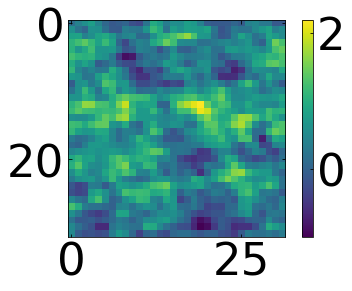

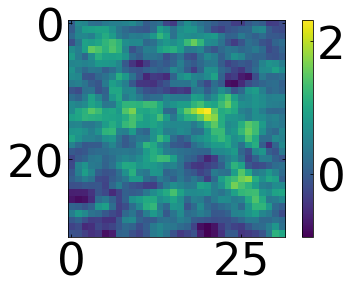

In [90]:
plt.figure()
plt.imshow(ts)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ts2)
plt.colorbar()
plt.show()

1 thread: ~77 seconds

4 threads: ~38 seconds

8 threads (2 row, 4 col): ~40 seconds

8 threads (4 row, 2 col): ~35 seconds

16 threads: ~ 50 seconds

64 threads: ~170 seconds

# scratch

In [20]:
condition = np.logical_and(np.array(candidxs)[:,2]==0,np.array(candidxs)[:,3]==0)
condition2 = np.logical_and(np.array(candidxs)[:,1] < 20,np.array(candidxs)[:,1] > 10)
condition2 = np.logical_and(condition2,np.array(candidxs)[:,0] > 10)
condition2 = np.logical_and(condition2,np.array(candidxs)[:,0] < 20)

plt.figure()
plt.hist(np.array(cands)[:,-1],np.linspace(0,1100),alpha=0.5)
plt.hist(np.array(cands)[condition,-1],np.linspace(0,1100),alpha=0.5)
plt.hist(np.array(cands)[condition2,-1],np.linspace(0,1100),alpha=0.5)
plt.axvline(1000)
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [29]:
np.logspace(0,8,9)

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])

[8.324635823197222e-07, 8.407485604808241e-07, 8.335947000048973e-07, 8.327954862484645e-07, 8.291641921297809e-07, 8.385392646010649e-07, 8.366433034024192e-07, 8.333376736337169e-07, 8.348761148205121e-07, 8.315558826342026e-07, 8.356252095591347e-07, 8.362305236684597e-07, 8.286488776468858e-07, 8.387309162506212e-07, 8.29709404652388e-07, 8.281959304522467e-07]
Spatial matched filtering with DSA PSF...
Using 2D FFT method...
Done!
---> 0
Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0

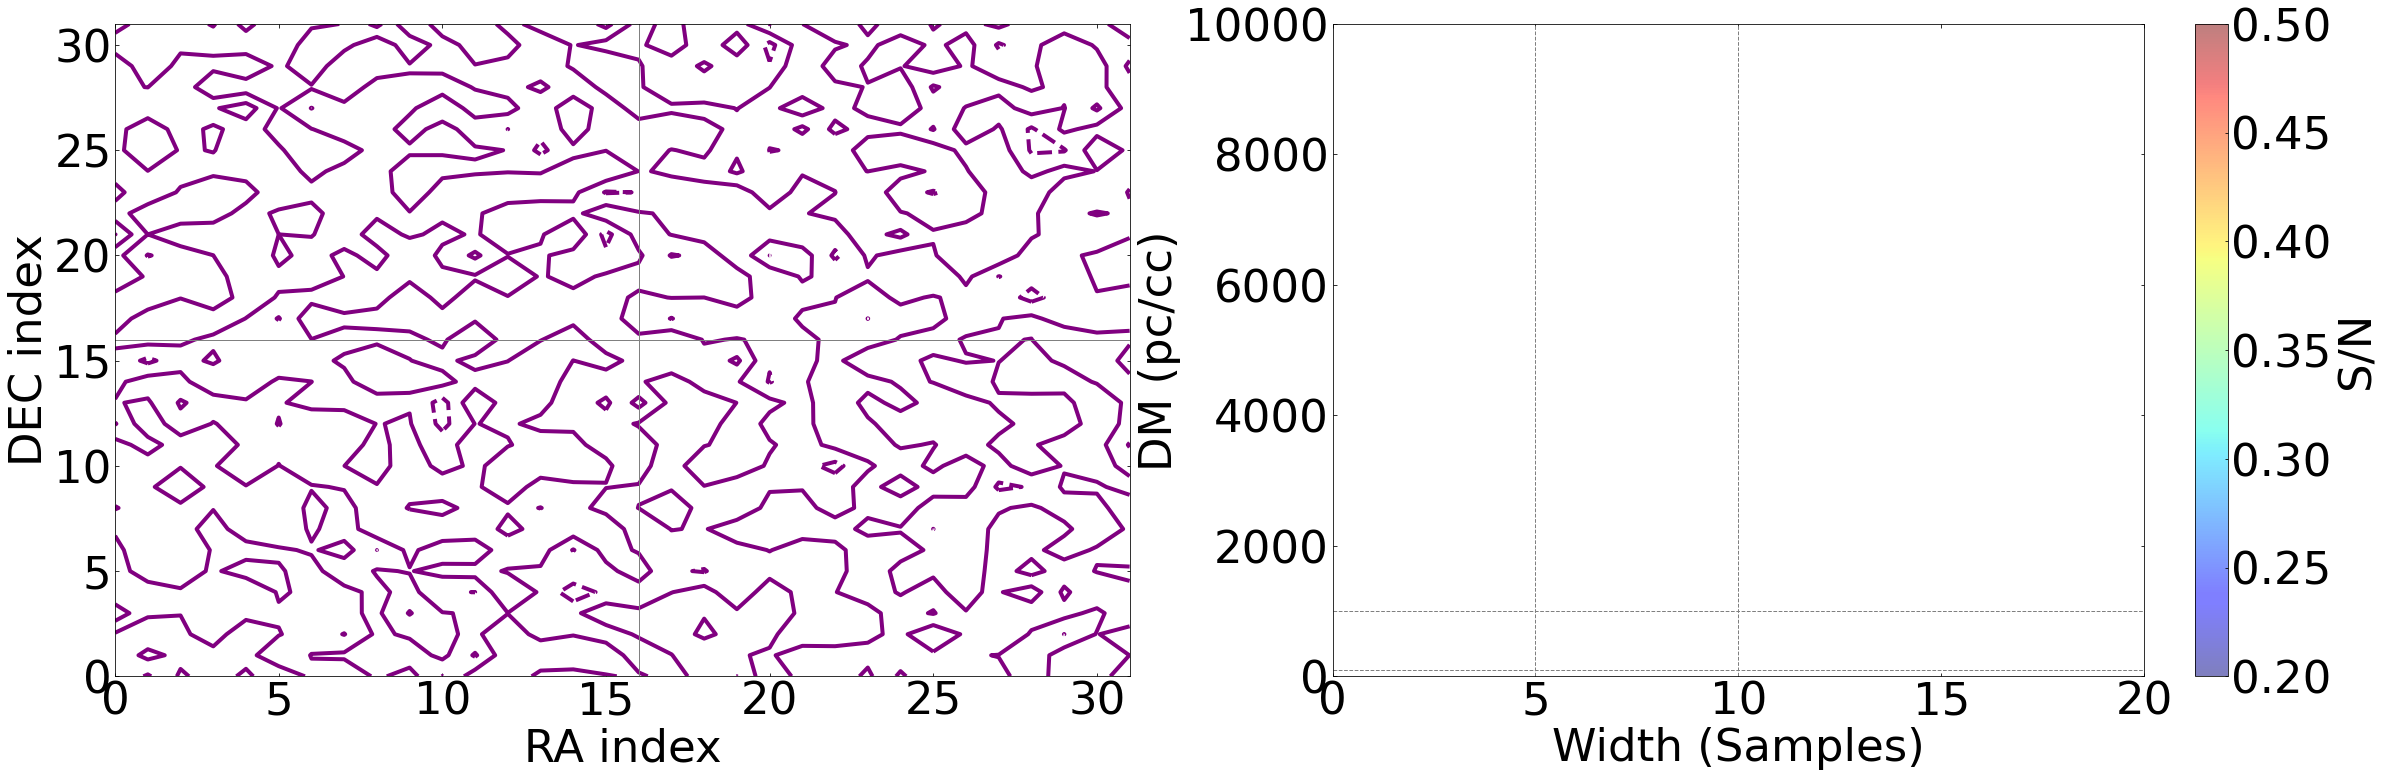

[8.324635823197222e-07, 8.407485604808241e-07, 8.335947000048973e-07, 8.327954862484645e-07, 8.291641921297809e-07, 8.385392646010649e-07, 8.366433034024192e-07, 8.333376736337169e-07, 8.348761148205121e-07, 8.315558826342026e-07, 8.356252095591347e-07, 8.362305236684597e-07, 8.286488776468858e-07, 8.387309162506212e-07, 8.29709404652388e-07, 8.281959304522467e-07]
Spatial matched filtering with DSA PSF...
Using 2D FFT method...
Done!
---> 0
Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0

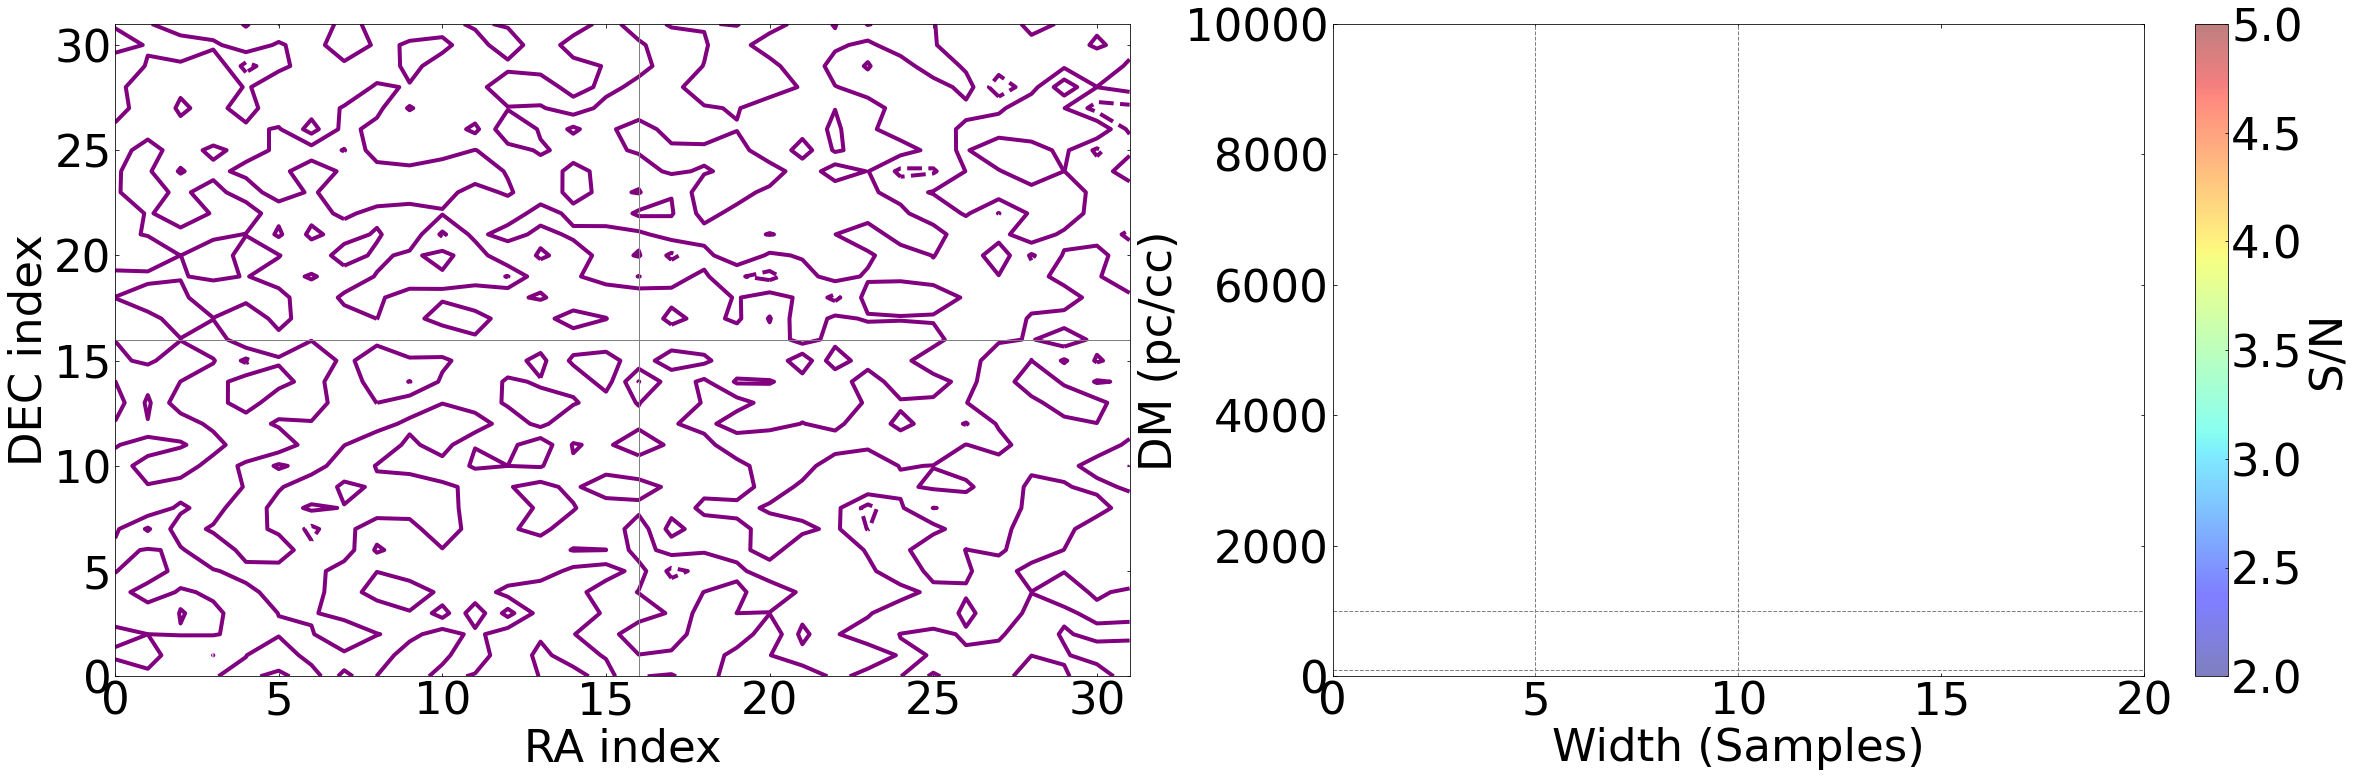

[8.324635823197222e-07, 8.407485604808241e-07, 8.335947000048973e-07, 8.327954862484645e-07, 8.291641921297809e-07, 8.385392646010649e-07, 8.366433034024192e-07, 8.333376736337169e-07, 8.348761148205121e-07, 8.315558826342026e-07, 8.356252095591347e-07, 8.362305236684597e-07, 8.286488776468858e-07, 8.387309162506212e-07, 8.29709404652388e-07, 8.281959304522467e-07]
Spatial matched filtering with DSA PSF...
Using 2D FFT method...
Done!
---> 0
Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0

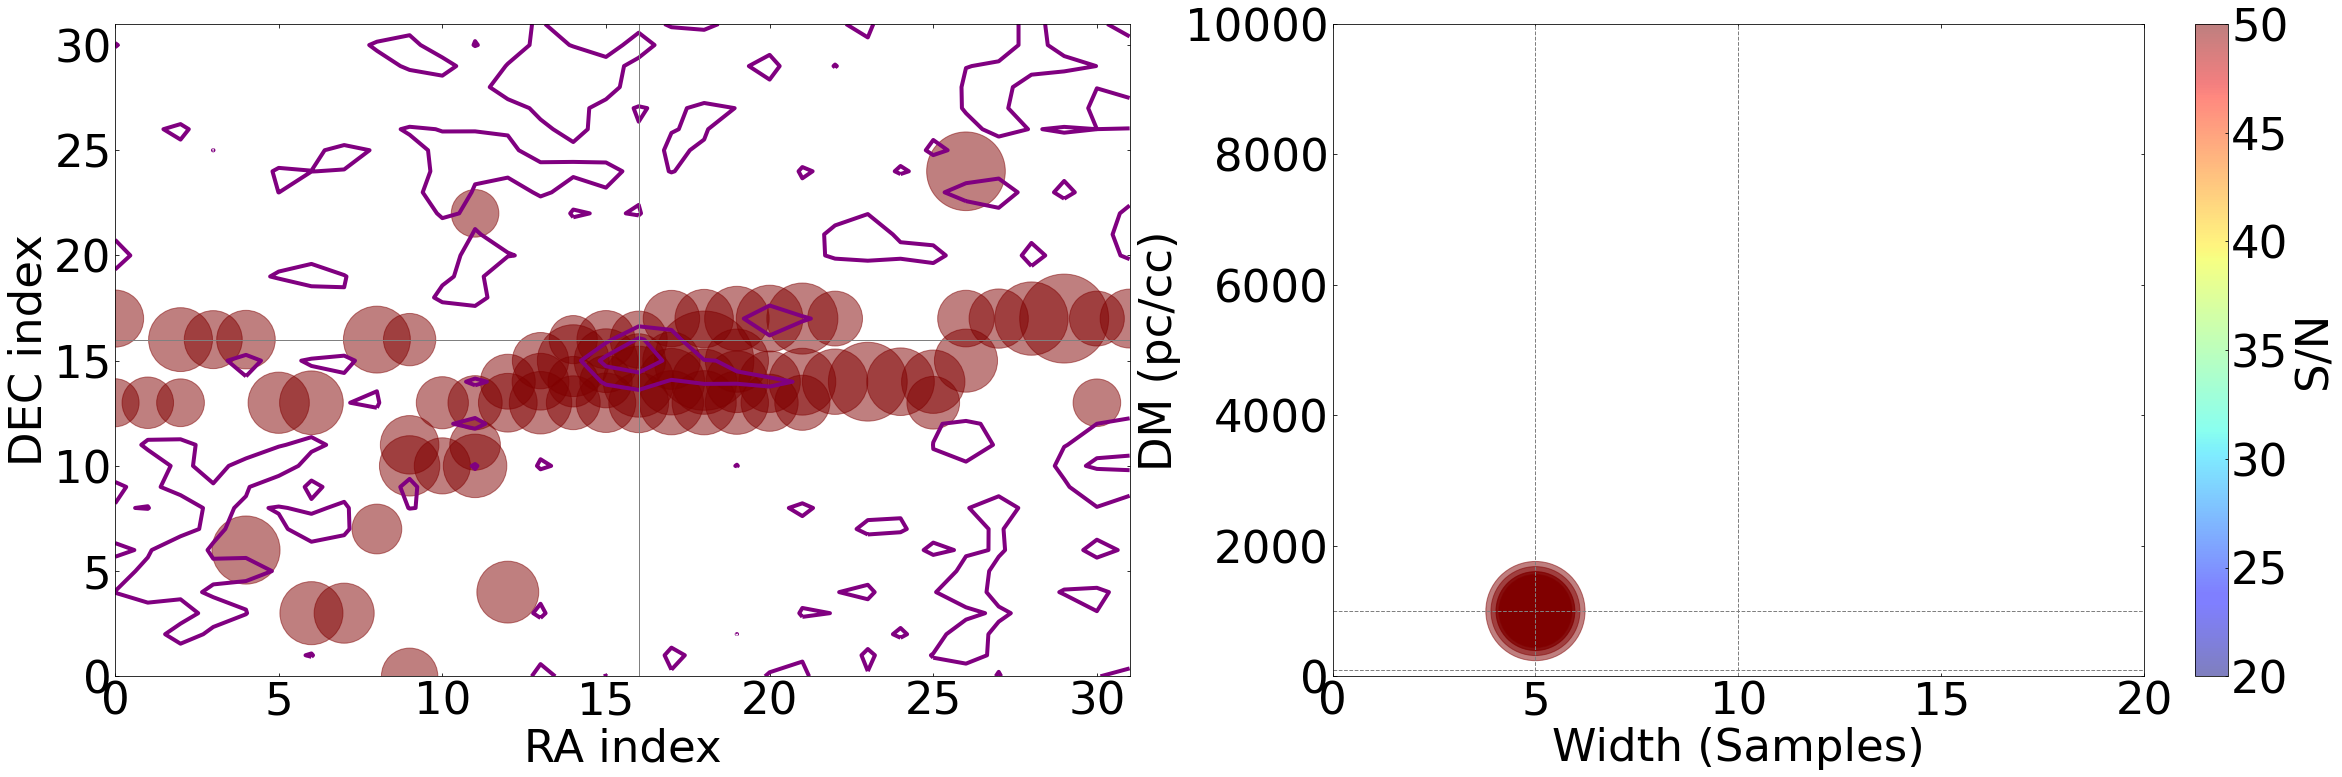

[8.324635823197222e-07, 8.407485604808241e-07, 8.335947000048973e-07, 8.327954862484645e-07, 8.291641921297809e-07, 8.385392646010649e-07, 8.366433034024192e-07, 8.333376736337169e-07, 8.348761148205121e-07, 8.315558826342026e-07, 8.356252095591347e-07, 8.362305236684597e-07, 8.286488776468858e-07, 8.387309162506212e-07, 8.29709404652388e-07, 8.281959304522467e-07]
Spatial matched filtering with DSA PSF...
Using 2D FFT method...
Done!
---> 0
Starting dedispersion with 3 trials...
Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0


KeyboardInterrupt



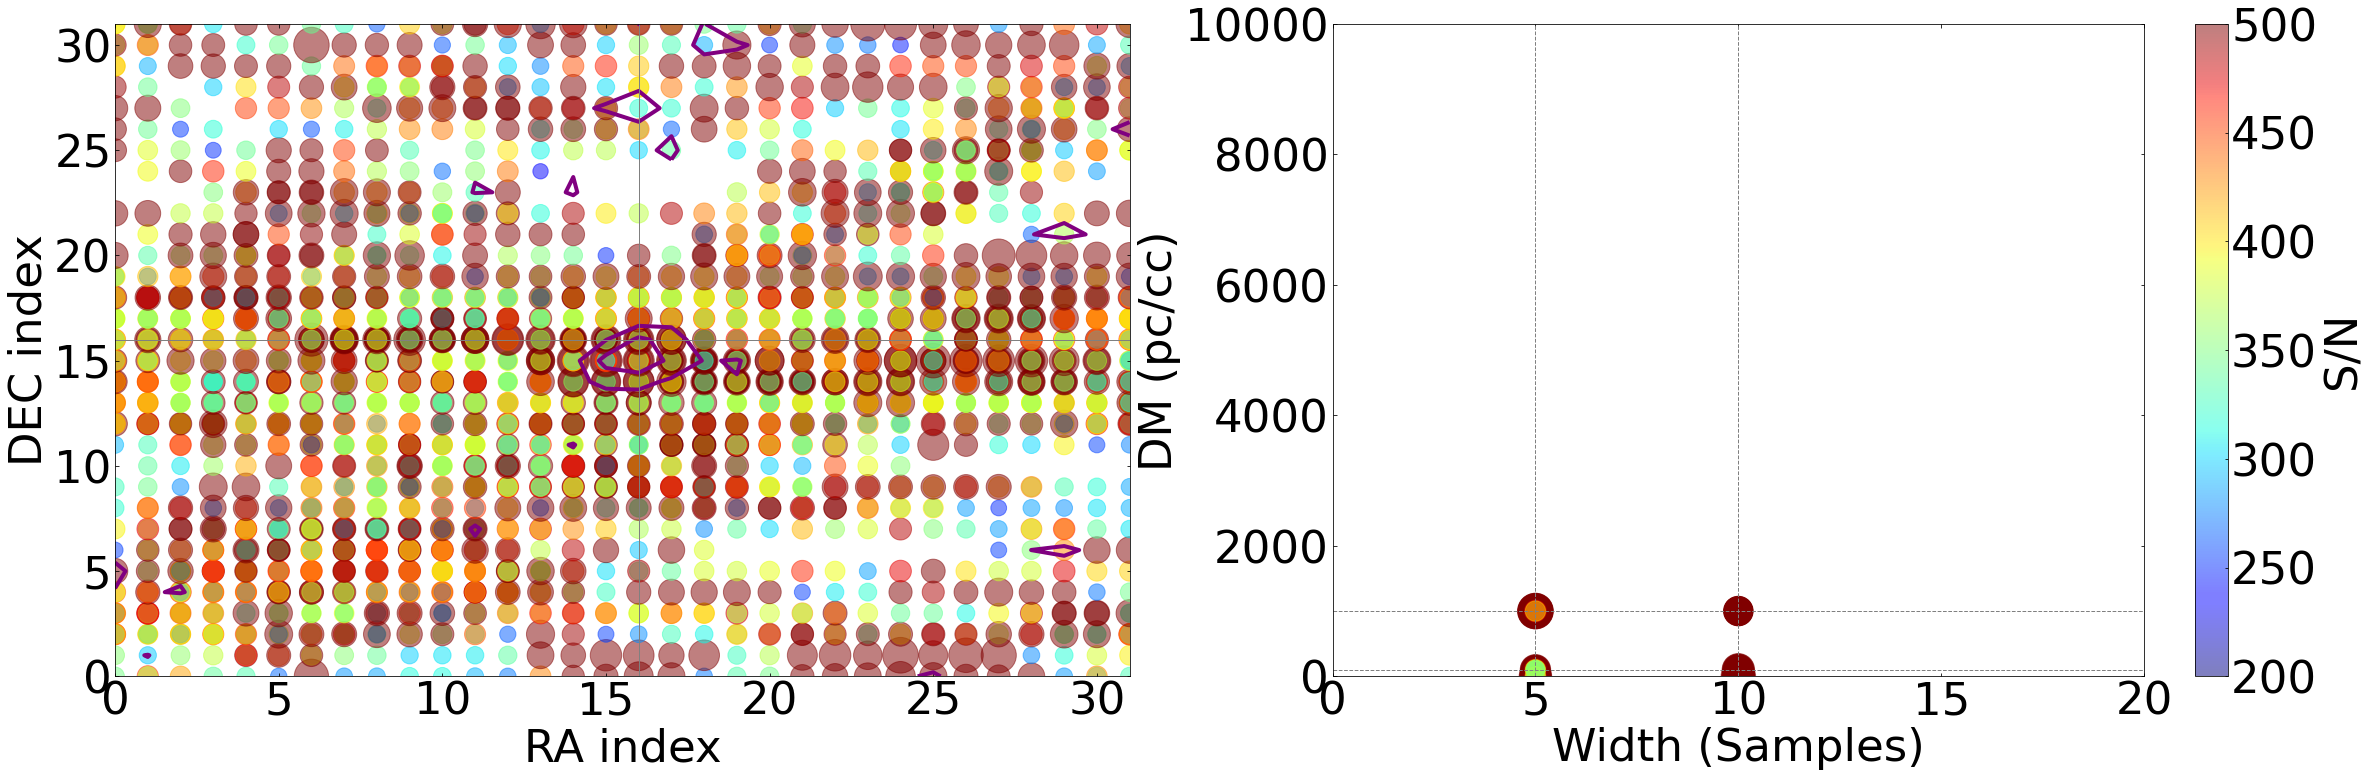

In [30]:

# try simulated images with different dms, widths and plot 68% confidence interval
snrout = []
snrout_low = []
snrout_upp = []

snrout2 = []
snrout_low2 = []
snrout_upp2 = []
snrtrials = np.logspace(0,8,9)
for snr in snrtrials:
    img = sl.make_image_cube(PSFimg=PSFimg,snr=snr,gridsize=32,nsamps=75,DM=0)
    
    candidxs,cands,imgsearched,imgbinned=sl.run_search_new(img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),
                                                           time_axis=np.arange(75)*sl.tsamp,freq_axis=sl.freq_axis,
                       DM_trials=dmt,widthtrials=np.array([5,10]),
                                                           tsamp=sl.tsamp,SNRthresh=0,plot=False,
                       off=10,PSF=PSFimg,offpnoise=0.3,verbose=False,output_file="",noiseth=1e-2,canddict=canddict,usefft=True)
    sl.search_plots_new(canddict,img,RA_axis=np.arange(gsize),DEC_axis=np.arange(gsize),DM_trials=dmt,widthtrials=np.array([5,10]),vmin=200*snr/1000,vmax=500*snr/1000,s100=snr/10)
    if len(cands) > 0:
        condition = np.logical_and(np.array(candidxs)[:,2]==0,np.array(candidxs)[:,3]==0)
        
        snrout.append(np.nanmedian(np.array(cands)[condition,-1]))
        snrout_upp.append(np.nanpercentile(np.array(cands)[condition,-1],84) - snrout[-1])
        snrout_low.append(snrout[-1] - np.nanpercentile(np.array(cands)[condition,-1],16))

        condition2 = np.logical_and(np.array(candidxs)[:,1] < 20,np.array(candidxs)[:,1] > 10)
        condition2 = np.logical_and(condition2,np.array(candidxs)[:,0] > 10)
        condition2 = np.logical_and(condition2,np.array(candidxs)[:,0] < 20)

        snrout2.append(np.nanmedian(np.array(cands)[condition2,-1]))
        snrout_upp2.append(np.nanpercentile(np.array(cands)[condition2,-1],84) - snrout2[-1])
        snrout_low2.append(snrout2[-1] - np.nanpercentile(np.array(cands)[condition2,-1],16))

            
    else:
        snrout.append(np.nan)
        snrout_upp.append(np.nan)
        snrout_low.append(np.nan)
        
        snrout2.append(np.nan)
        snrout_upp2.append(np.nan)
        snrout_low2.append(np.nan)
        



ValueError: 'x' and 'y' must have the same size

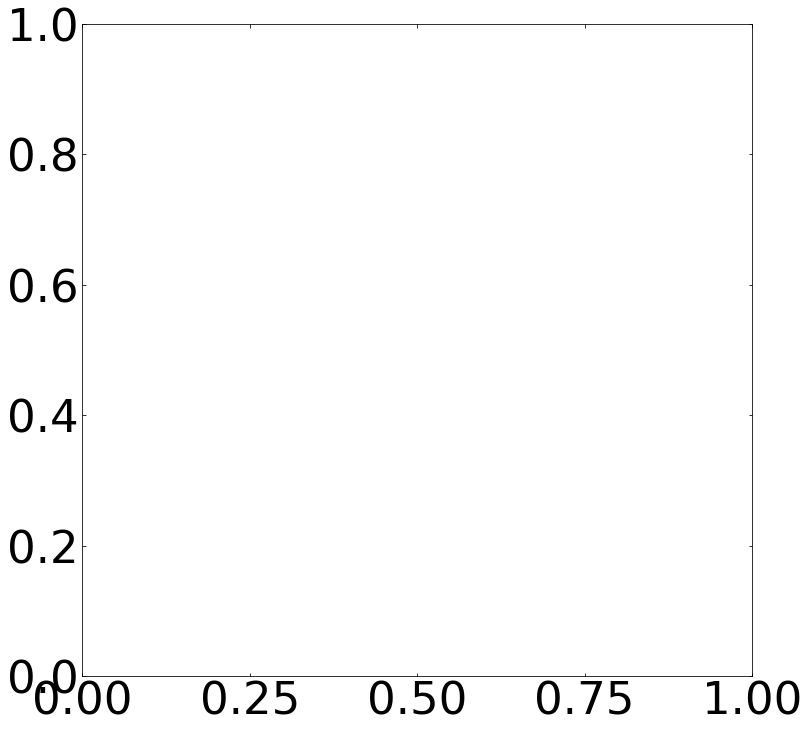

In [31]:
plt.figure(figsize=(12,12))
plt.errorbar(snrtrials,snrout,yerr=[snrout_low,snrout_upp],marker='o')
plt.plot(snrtrials,snrtrials,color='red')
plt.xlabel("Input S/N")
plt.ylabel("Output S/N")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
#prune inf candidates
cands_noninf = []
for i in candidxs:
    if not np.isinf(i[-1]): cands_noninf.append(i)

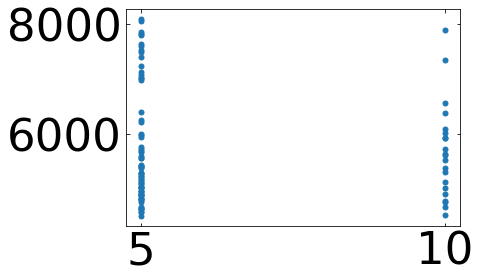

In [11]:
plt.figure()
plt.plot(wt[np.array(cands_noninf,dtype=int)[:,2]],
         np.array(cands_noninf,dtype=int)[:,-1],'o')
plt.show()

In [9]:
centroid_cands

[(27.736720022776343,
  16.57871759577049,
  0.0,
  0.43498253530008096,
  5103.700002256608),
 (15.118429797623746,
  15.287981031088899,
  0.22839677019960591,
  0.4375152659773259,
  5734.094682095751),
 (5.86043288171744,
  16.656220261631894,
  0.0,
  0.4862779736010563,
  5085.012611605946)]

78 candidates
11 noise points
3 unique classes


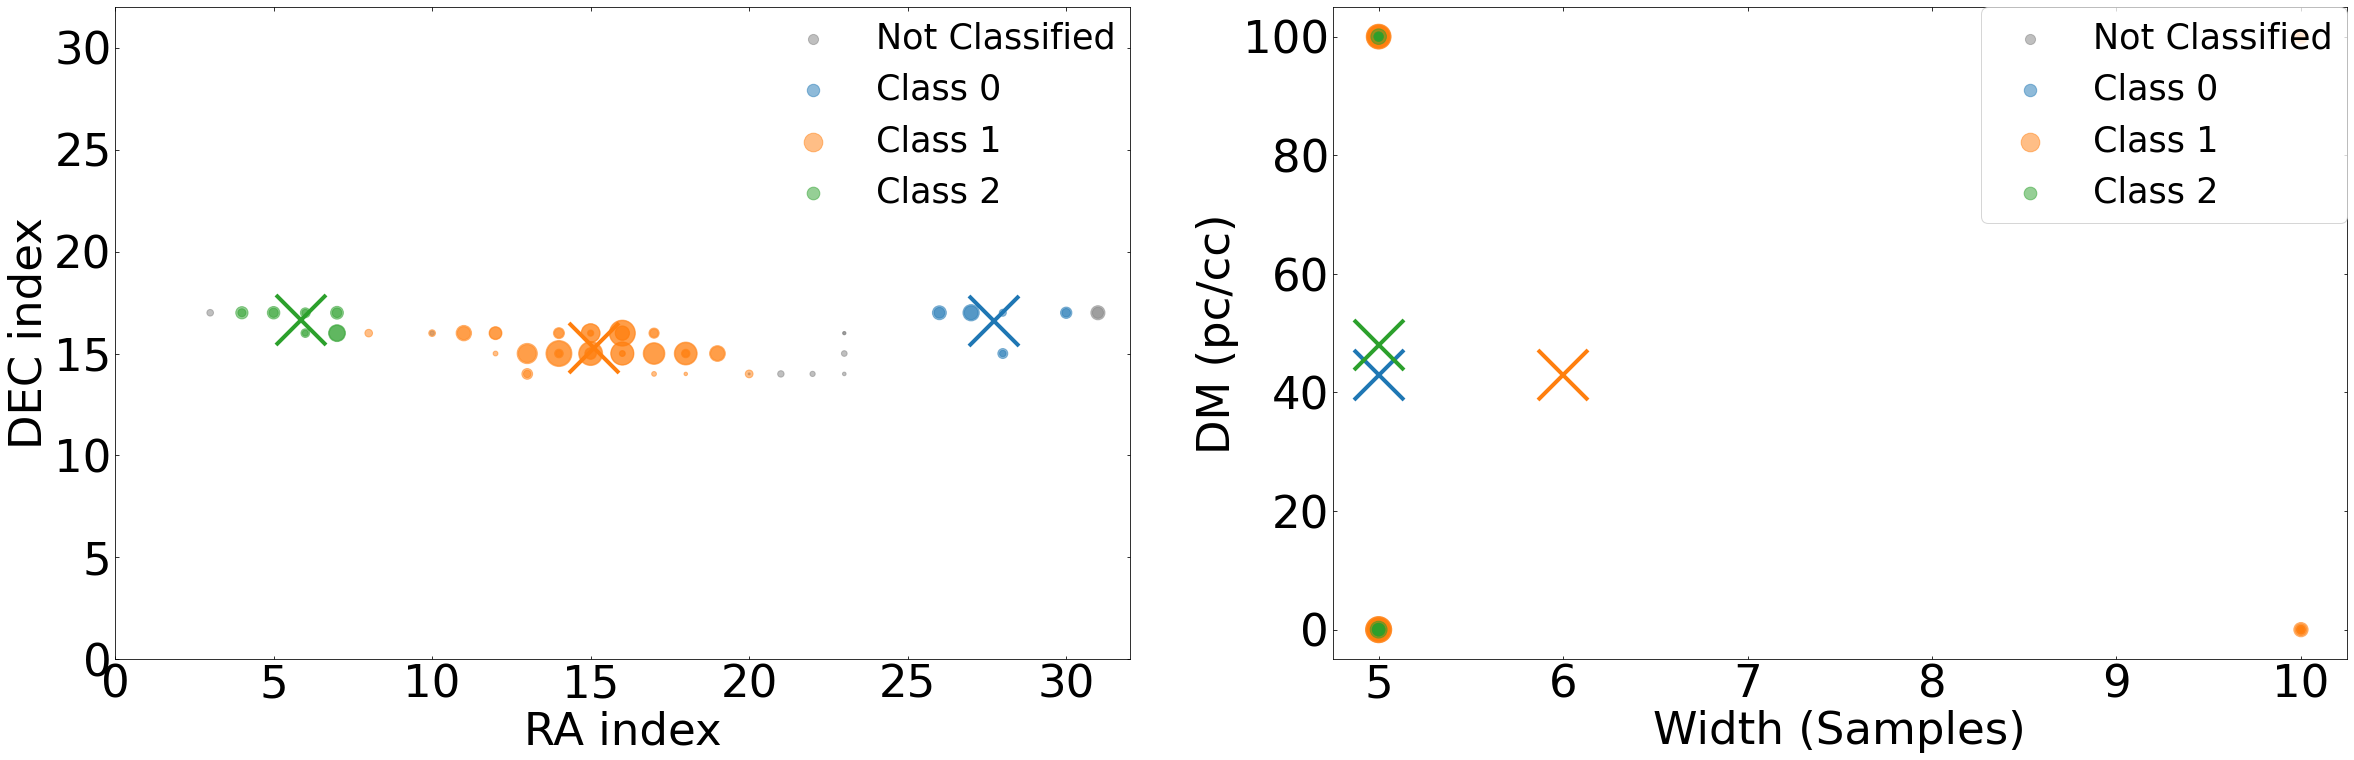

In [8]:
#testing hdbscan
import hdbscan
classes,centroid_cands,centroid_ras,centroid_decs,centroid_dms,centroid_widths,centroid_snrs = sl.hdbscan_cluster(cands_noninf,min_cluster_size=5,gridsize=32,nDMtrials=3,nwidths=2,dmt=dmt,wt=wt,plot=True,show=True,SNRthresh=4500,)

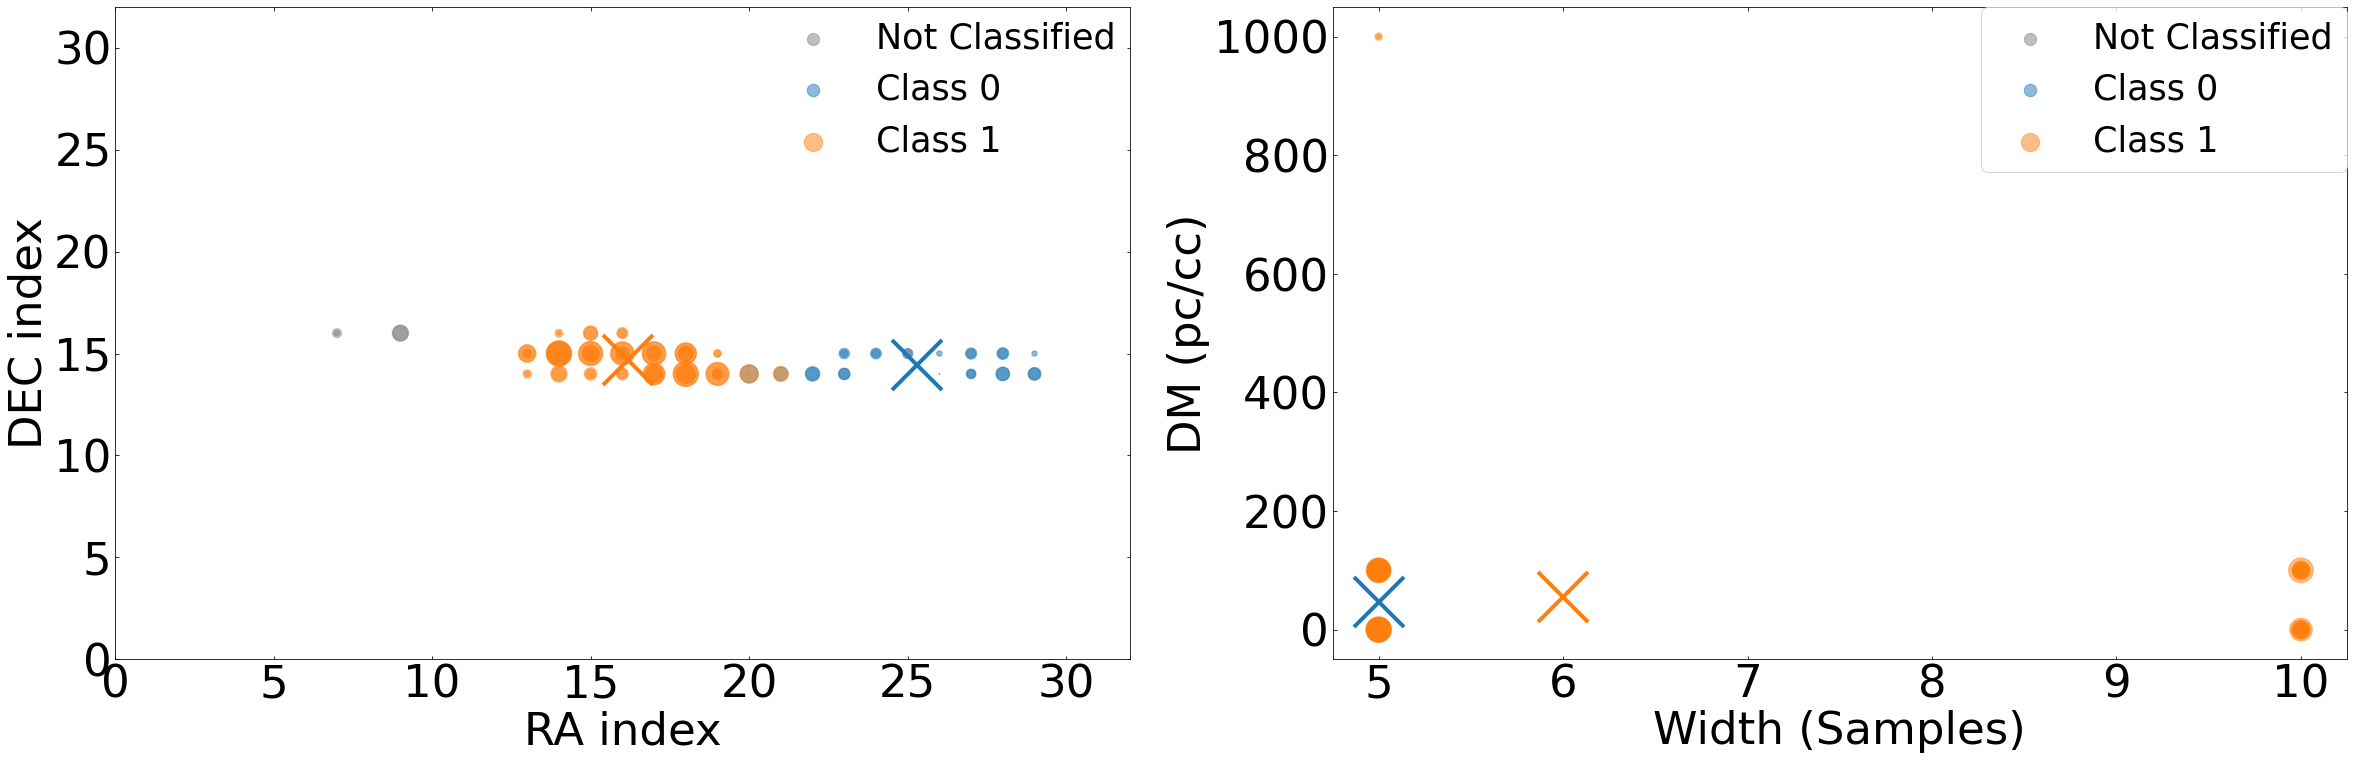

In [7]:
from scipy.interpolate import interp1d
plt.figure(figsize=(40,12))
plt.subplot(121)
#plt.plot(np.array(cands_noninf)[:,0][classes==0],np.array(cands_noninf)[:,1][classes==0],'o')
for i in range(-1,len(np.unique(classes))-int(-1 in classes)):
    if i == -1:
        plt.scatter(np.array(cands_noninf)[classes==i,0],np.array(cands_noninf)[classes==i,1],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==i,-1] - 4500)/(10000 - 4500),label='Not Classified',color='grey')
    else:
        c=plt.plot(centroid_ras[i],centroid_decs[i],'x',markersize=50,markerfacecolor="none",markeredgewidth=4)
        plt.scatter(np.array(cands_noninf)[classes==i,0],np.array(cands_noninf)[classes==i,1],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==i,-1] - 4500)/(10000 - 4500),label='Class ' + str(i),c=c[0].get_color())

#plt.scatter(np.array(cands_noninf)[classes==0,0],np.array(cands_noninf)[classes==0,1],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==0,-1] - 4500)/(10000 - 4500))
plt.xlim(0,32)
plt.ylim(0,32)
plt.xlabel("RA index")
plt.ylabel("DEC index")
plt.legend(loc='upper right')

plt.subplot(122)
wtinterp = interp1d(np.arange(len(wt)),wt,fill_value='extrapolate')
dmtinterp = interp1d(np.arange(len(dmt)),dmt,fill_value='extrapolate')
#plt.plot(np.array(cands_noninf)[:,0][classes==0],np.array(cands_noninf)[:,1][classes==0],'o')
for i in range(-1,len(np.unique(classes))-int(-1 in classes)):
    if i == -1:
        plt.scatter(wt[np.array(cands_noninf,dtype=int)[classes==i,2]],dmt[np.array(cands_noninf,dtype=int)[classes==i,3]],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==i,-1] - 4500)/(10000 - 4500),label='Not Classified',color='grey')
    else:
        c=plt.plot(int(wtinterp(centroid_widths[i])),int(dmtinterp(centroid_dms[i])),'x',markersize=50,markerfacecolor="none",markeredgewidth=4)
        plt.scatter(wt[np.array(cands_noninf,dtype=int)[classes==i,2]],dmt[np.array(cands_noninf,dtype=int)[classes==i,3]],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==i,-1] - 4500)/(10000 - 4500),label='Class ' + str(i),c=c[0].get_color())
#plt.scatter(np.array(cands_noninf)[classes==0,2],np.array(cands_noninf)[classes==0,3],alpha=0.5,s=1000*(np.array(cands_noninf)[classes==0,-1] - 4500)/(10000 - 4500))
#plt.xlim(0,32)
#plt.ylim(0,32)
plt.xlabel("Width (Samples)")
plt.ylabel("DM (pc/cc)")
plt.legend(loc='upper right',frameon=True)
plt.show()

In [9]:
centroid_widths

array([0.        , 0.33600013])

In [79]:
centroid_widths

array([0.        , 0.19167679])

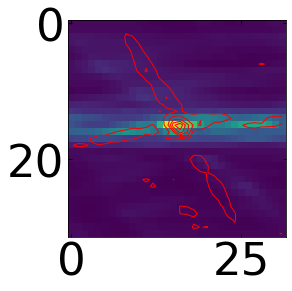

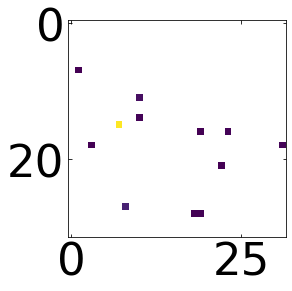

In [13]:
plt.figure()
plt.imshow(np.abs(np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(np.fft.fft(img.mean(3)[:,:,75//2]))*np.fft.fftshift(np.fft.fft(PSFimg.mean(3)[:,:,75//2]))))))
plt.contour(img.mean(3)[:,:,75//2],colors='red')
plt.show()

plt.figure()
plt.imshow(imgsearched[:,:,0,0])
plt.imshow(imgsearched[:,:,1,0])
plt.show()

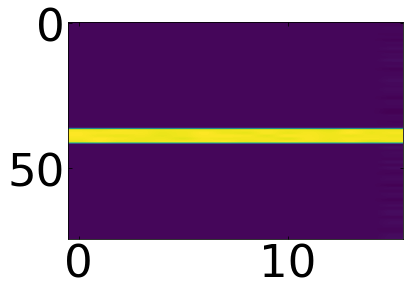

In [9]:
plt.figure()
plt.imshow(sl.matched_filter_space(img,PSFimg,usefft=True)[150,150,:,:],aspect='auto')
plt.show()

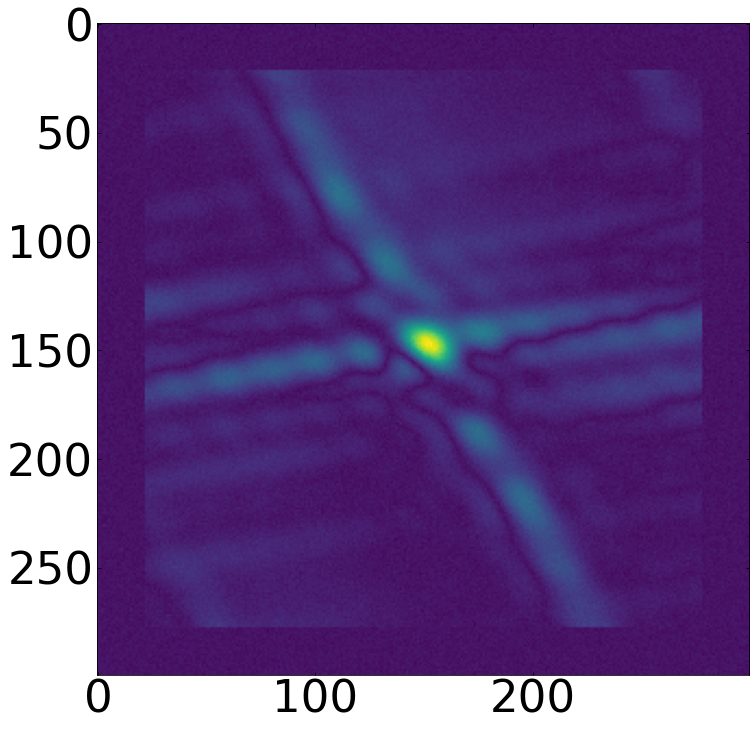

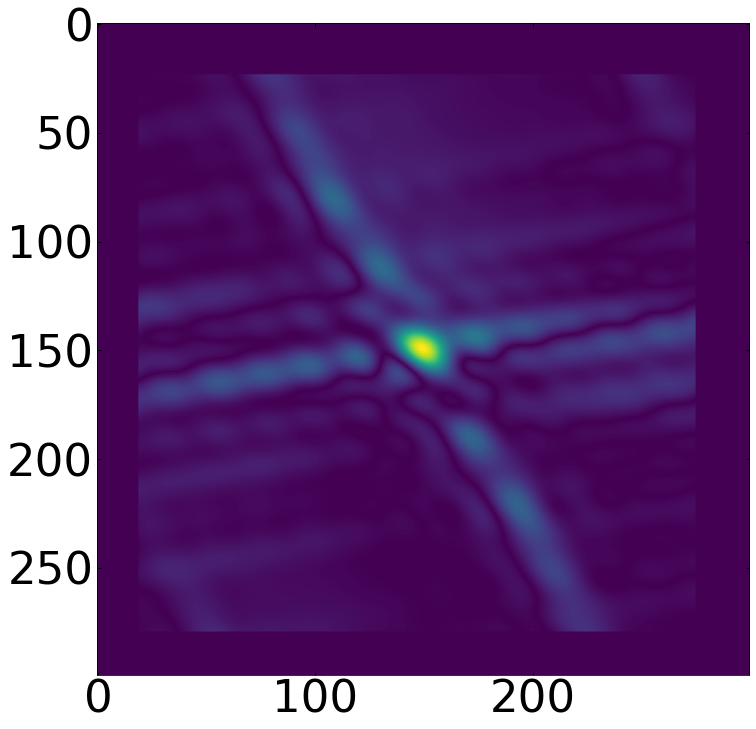

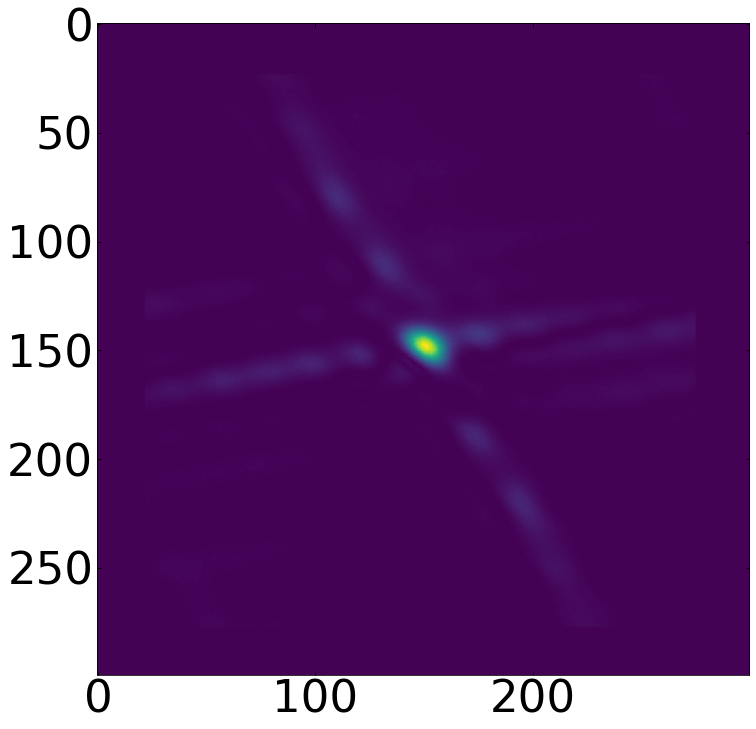

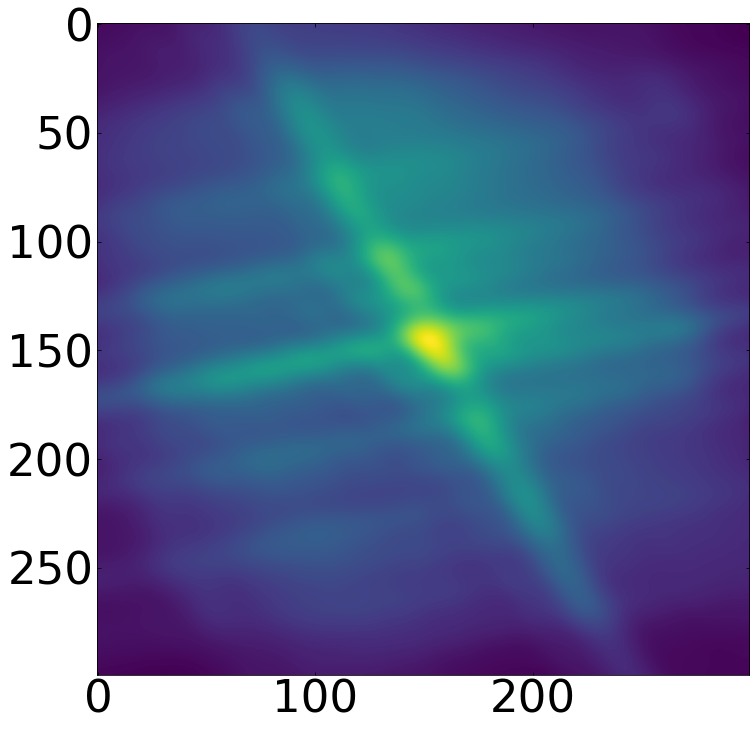

In [43]:
plt.figure(figsize=(12,12))
plt.imshow(img.mean((2,3)))
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(PSFimg.mean((2,3)))
plt.show()

for i in range(32):
    imgnew = np.fft.fftshift(np.fft.fftshift(img.mean((2,3)))*np.fft.fftshift(PSFimg.mean((2,3))))

"""plt.figure(figsize=(12,12))
plt.imshow(np.real(np.fft.fft2(img.mean((2,3)))))
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(np.real(np.fft.fft2(PSFimg.mean((2,3)))))
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(np.real(np.fft.fft2(PSFimg.mean((2,3)))*np.fft.fft2(img.mean((2,3)))))
plt.show()"""
plt.figure(figsize=(12,12))
plt.imshow(np.real(imgnew))
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(convolve2d(img.mean((2,3)),PSFimg.mean((2,3)),mode='same'))
plt.show()



# test dedisp

In [3]:
help(np.pad)


Help on function pad in module numpy:

pad(array, pad_width, mode='constant', **kwargs)
    Pad an array.
    
    Parameters
    ----------
    array : array_like of rank N
        The array to pad.
    pad_width : {sequence, array_like, int}
        Number of values padded to the edges of each axis.
        ((before_1, after_1), ... (before_N, after_N)) unique pad widths
        for each axis.
        ((before, after),) yields same before and after pad for each axis.
        (pad,) or int is a shortcut for before = after = pad width for all
        axes.
    mode : str or function, optional
        One of the following string values or a user supplied function.
    
        'constant' (default)
            Pads with a constant value.
        'edge'
            Pads with the edge values of array.
        'linear_ramp'
            Pads with the linear ramp between end_value and the
            array edge value.
        'maximum'
            Pads with the maximum value of all or part of

In [16]:
x1 = np.array([[[np.arange(16)]*25]*32]*32)

In [17]:
x1.shape

(32, 32, 25, 16)

In [12]:
np.pad(x1,pad_width=[(0,0),(0,0),(0,0),(0,5)])[:,:,:,0]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
x1.reshape((32*32,25,16)).shape

(1024, 25, 16)

In [106]:
# Brute force dedispersion
def dedisperse(image_tesseract_point,DM,tsamp=sl.tsamp,freq_axis=sl.freq_axis,output_file=""):
    """
    This function dedisperses a dynamic spectrum of shape nsamps x nchans by brute force without accounting for edge effects
    """
    if output_file != "":
        fout = open(output_file,"a")
    else:
        fout = sys.stdout

    #get delay axis
    neg_flag = DM < 0
    DM = np.abs(DM)

    #Delays
    tdelays = DM*4.15*(((np.min(freq_axis)*1e-3)**(-2)) - ((freq_axis*1e-3)**(-2)))#(8.3*(chanbw)*burst_DMs[i]/((freq_axis*1e-3)**3))*(1e-3) #ms
    tdelays_idx_hi = np.array(np.ceil(tdelays/tsamp),dtype=int)
    tdelays_idx_low = np.array(np.floor(tdelays/tsamp),dtype=int)
    tdelays_frac = tdelays/tsamp - tdelays_idx_low
    print("Trial DM: " + str(DM) + " pc/cc, DM delays (ms): " + str(tdelays) + "...",file=fout,end="")
    nchans = len(freq_axis)
    nsamps = image_tesseract_point.shape[-2]
    dedisp_timeseries_all = np.zeros(image_tesseract_point.shape[:-1])
    dedisp_img = np.zeros(image_tesseract_point.shape)
    #shift each channel
    for k in range(nchans):
        #print(tdelays_idx_hi,tdelays_idx_low,tdelays_frac);
        if neg_flag:
            padshape = tuple([(0,0)]*(len(dedisp_timeseries_all.shape)-1) + [(tdelays_idx_low[k],0)])
            arrlow =  np.pad(image_tesseract_point[:,:,:,k],padshape,mode="constant",constant_values=0)[:,:,:nsamps]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)
        else:
            padshape = tuple([(0,0)]*(len(dedisp_timeseries_all.shape)-1) + [(0,tdelays_idx_low[k])])
            arrlow =  np.pad(image_tesseract_point[:,:,:,k],padshape,mode="constant",constant_values=0)[:,:,tdelays_idx_low[k]:]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)
        print(padshape)

        if neg_flag:
            padshape = tuple([(0,0)]*(len(dedisp_timeseries_all.shape)-1) + [(tdelays_idx_hi[k],0)])
            arrhi =  np.pad(image_tesseract_point[:,:,:,k],padshape,mode="constant",constant_values=0)[:,:,:nsamps]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)
        else:
            padshape = tuple([(0,0)]*(len(dedisp_timeseries_all.shape)-1) + [(0,tdelays_idx_hi[k])])
            arrhi =  np.pad(image_tesseract_point[:,:,:,k],padshape,mode="constant",constant_values=0)[:,:,tdelays_idx_hi[k]:]/nchans#np.roll(image_tesseract_intrinsic[:,:,:,k],tdelays_idx[k],axis=2)

        print(padshape)

        dedisp_timeseries_all += arrlow*(1-tdelays_frac[k]) + arrhi*(tdelays_frac[k])
        dedisp_img[:,:,:,k] = arrlow*(1-tdelays_frac[k]) + arrhi*(tdelays_frac[k])
    print("Done!",file=fout)
    if output_file != "":
        fout.close()
    return dedisp_timeseries_all,dedisp_img

In [41]:
dedisperse(x1,0)

Trial DM: 0 pc/cc, DM delays (ms): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
Done!


array([[[7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        ...,
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5]],

       [[7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        ...,
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5]],

       [[7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        ...,
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5]],

       ...,

       [[7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5],
        [7.5, 7.5, 7.5, ..., 7.5, 7.5, 7.5

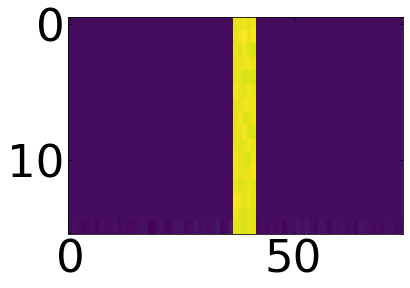

Trial DM: 10000 pc/cc, DM delays (ms): [   0.          646.96152382 1269.44915473 1868.68193488 2445.80394041
 3001.88974631 3537.94943207 4054.93317171 4553.73544717 5035.19891999
 5500.11799257 5949.24208715 6383.27866771 6802.89602775 7208.72586424
 7601.36565647]...((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (0, 0))
((0, 0), (0, 0), (4, 0))
((0, 0), (0, 0), (5, 0))
((0, 0), (0, 0), (9, 0))
((0, 0), (0, 0), (10, 0))
((0, 0), (0, 0), (14, 0))
((0, 0), (0, 0), (15, 0))
((0, 0), (0, 0), (18, 0))
((0, 0), (0, 0), (19, 0))
((0, 0), (0, 0), (23, 0))
((0, 0), (0, 0), (24, 0))
((0, 0), (0, 0), (27, 0))
((0, 0), (0, 0), (28, 0))
((0, 0), (0, 0), (31, 0))
((0, 0), (0, 0), (32, 0))
((0, 0), (0, 0), (35, 0))
((0, 0), (0, 0), (36, 0))
((0, 0), (0, 0), (38, 0))
((0, 0), (0, 0), (39, 0))
((0, 0), (0, 0), (42, 0))
((0, 0), (0, 0), (43, 0))
((0, 0), (0, 0), (45, 0))
((0, 0), (0, 0), (46, 0))
((0, 0), (0, 0), (49, 0))
((0, 0), (0, 0), (50, 0))
((0, 0), (0, 0), (52, 0))
((0, 0), (0, 0), (53, 0))
((0, 0)

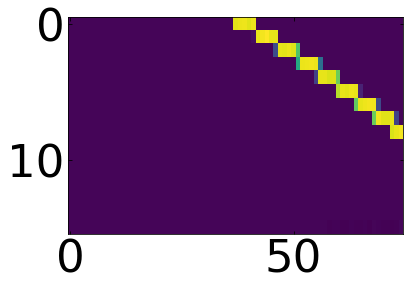

In [116]:
plt.figure()
plt.imshow(img[15,15,:,:].transpose(),aspect='auto')
plt.show()

plt.figure()
plt.imshow((dedisperse(img,-10000)[1])[15,15,:,:].transpose(),aspect='auto')
plt.show()